In [1]:
import copy
import gc
import itertools
import os
import pickle
import pprint
import random
import re
import time
import warnings
from collections import Counter, defaultdict
from functools import reduce
from itertools import cycle
from random import choice, choices

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# import catboost as cb
import optuna
import pandas as pd
import polars as pl
import seaborn as sns
import umap
import xgboost as xgb
from catboost import CatBoostRegressor
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    preprocessing,
    tree,
)
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

# from gensim.models import Word2Vec
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    PowerTransformer,
    RobustScaler,
)
from sklearn.svm import SVR
from tqdm import tqdm
from tqdm.autonotebook import tqdm
from xgboost import XGBRegressor

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.__version__

'2.0.3'

In [3]:
lgb.__version__

'3.3.2'

In [4]:
class MyConfig:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 5
    num_estimators = 12001
    num_trials_early_stopping = 200

    response_variate = "score"
    is_local = True
    use_optuna_tuning = True
    test_size_local = 0.2
    num_trials_optuna = 50

    num_features_to_display = 50
    vector_size = 64
    umap_filename = "count_vectoriser_umap2.sav"
    use_lgb_ftr_selection = True
    num_top_features = 300

In [5]:
cnfg = MyConfig()

In [6]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)
np.random.seed(cnfg.seed)

# Import Data

In [7]:
traindf = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")

if cnfg.is_local:
    train_scores, test_scores = train_test_split(
        train_scores,
        test_size=cnfg.test_size_local,
        random_state=cnfg.seed,
        stratify=train_scores.score,
    )
    train_scores = train_scores.reset_index(drop=True)
    test_scores = test_scores.reset_index(drop=True)
    testdf = traindf[traindf.id.isin(test_scores.id.unique())].reset_index(drop=True)
    traindf = traindf[traindf.id.isin(train_scores.id.unique())].reset_index(drop=True)
else:
    testdf = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [8]:
traindf.shape, testdf.shape

((6719293, 11), (1686605, 11))

## Essay Constructor

In [9]:
def getEssays(df):
    # Copy required columns
    textInputDf = df[["id", "activity", "cursor_position", "text_change"]].copy()

    # Get rid of text inputs that make no change
    # Note: Shift was unpreditcable so ignored
    textInputDf = textInputDf[textInputDf.activity != "Nonproduction"]

    # Get how much each Id there is
    valCountsArr = textInputDf["id"].value_counts(sort=False).values

    # Holds the final index of the previous Id
    lastIndex = 0

    # Holds all the essays
    essaySeries = pd.Series()

    # Fills essay series with essays
    for index, valCount in enumerate(valCountsArr):
        # Indexes down_time at current Id
        currTextInput = textInputDf[
            ["activity", "cursor_position", "text_change"]
        ].iloc[lastIndex : lastIndex + valCount]

        # Update the last index
        lastIndex += valCount

        # Where the essay content will be stored
        essayText = ""

        # Produces the essay
        for Input in currTextInput.values:
            # Input[0] = activity
            # Input[2] = cursor_position
            # Input[3] = text_change

            # If activity = Replace
            if Input[0] == "Replace":
                # splits text_change at ' => '
                replaceTxt = Input[2].split(" => ")

                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(replaceTxt[1])]
                    + replaceTxt[1]
                    + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]) :]
                )
                continue

            # If activity = Paste
            if Input[0] == "Paste":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(Input[2])]
                    + Input[2]
                    + essayText[Input[1] - len(Input[2]) :]
                )
                continue

            # If activity = Remove/Cut
            if Input[0] == "Remove/Cut":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1]] + essayText[Input[1] + len(Input[2]) :]
                )
                continue

            # If activity = Move...
            if "M" in Input[0]:
                # Gets rid of the "Move from to" text
                croppedTxt = Input[0][10:]

                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(" To ")

                # Splits split text again by ', ' for each item
                valueArr = [item.split(", ") for item in splitTxt]

                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (
                    int(valueArr[0][0][1:]),
                    int(valueArr[0][1][:-1]),
                    int(valueArr[1][0][1:]),
                    int(valueArr[1][1][:-1]),
                )

                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[0]]
                            + essayText[moveData[1] : moveData[3]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[3] :]
                        )
                    else:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[2]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[2] : moveData[0]]
                            + essayText[moveData[1] :]
                        )
                continue

            # If just input
            # DONT TOUCH
            essayText = (
                essayText[: Input[1] - len(Input[2])]
                + Input[2]
                + essayText[Input[1] - len(Input[2]) :]
            )

        # Sets essay at index
        essaySeries[index] = essayText

    # Sets essay series index to the ids
    essaySeries.index = textInputDf["id"].unique()

    # Returns the essay series
    return essaySeries

In [10]:
%%time
train_essays = getEssays(traindf)

CPU times: user 1min 58s, sys: 44 s, total: 2min 42s
Wall time: 2min 42s


In [11]:
test_essays = getEssays(testdf)

In [12]:
train_essaysdf = pd.DataFrame({"id": train_essays.index, "essay": train_essays.values})
test_essaysdf = pd.DataFrame({"id": test_essays.index, "essay": test_essays.values})

In [13]:
merged_data = train_essaysdf.merge(train_scores, on="id")

## Using Tokenizer

In [14]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
# count_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tokenizer_train = count_vectorizer.fit_transform(merged_data["essay"])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf["essay"])

In [15]:
# dim_reduction_model = umap.UMAP(
#     n_components=64, metric="hellinger", random_state=cnfg.seed
# )
# dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)
# joblib.dump(dim_reduction_model, cnfg.umap_filename)

In [16]:
# dim_reduction_model = joblib.load(cnfg.umap_filename)

In [17]:
# dim_reduction_model = TruncatedSVD(n_components=64, n_iter=10, random_state=cnfg.seed)
# dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)

In [18]:
# dim_reduction_model

In [19]:
X_tokenizer_train.shape

(1976, 277)

In [20]:
X_tokenizer_test.shape

(495, 277)

In [21]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [22]:
X_tokenizer_train = np.array(X_tokenizer_train.todense())
X_tokenizer_test = np.array(X_tokenizer_test.todense())

In [23]:
# X_tokenizer_train = dim_reduction_model.transform(X_tokenizer_train)
# X_tokenizer_test = dim_reduction_model.transform(X_tokenizer_test)

In [24]:
X_tokenizer_train.shape, X_tokenizer_test.shape

((1976, 277), (495, 277))

## Create Features from the tokenizer

In [25]:
df_train = pd.DataFrame(
    X_tokenizer_train,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_train.shape[1])],
)

In [26]:
df_test = pd.DataFrame(
    X_tokenizer_test,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_test.shape[1])],
)

In [27]:
df_train_index = train_essaysdf["id"]
df_test_index = test_essaysdf["id"]

In [28]:
df_train.loc[:, "id"] = df_train_index
df_test.loc[:, "id"] = df_test_index

In [29]:
df_train

,token_feature_0,token_feature_1,token_feature_2,token_feature_3,token_feature_4,token_feature_5,token_feature_6,token_feature_7,token_feature_8,token_feature_9,...,token_feature_268,token_feature_269,token_feature_270,token_feature_271,token_feature_272,token_feature_273,token_feature_274,token_feature_275,token_feature_276,id
0,61,8,12,19,11,5,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0022f953
1,64,6,8,8,6,6,4,10,4,4,...,0,0,0,0,0,0,0,0,0,0042269b
2,44,6,7,8,4,6,6,1,1,2,...,0,0,0,0,0,0,0,0,0,0059420b
3,49,3,15,11,9,2,3,3,0,1,...,0,0,0,0,0,0,0,0,0,0075873a
4,59,12,3,17,12,6,2,2,0,3,...,0,0,0,0,0,0,0,0,0,0081af50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,49,5,4,9,13,7,7,0,1,0,...,0,0,0,0,0,0,0,0,0,ffb8c745
1972,74,16,9,21,10,7,4,4,1,1,...,0,0,0,0,0,0,0,0,0,ffbef7e5
1973,42,5,9,8,7,5,3,1,1,1,...,0,0,0,0,0,0,0,0,0,ffccd6fd
1974,80,5,19,12,11,6,11,2,1,5,...,0,0,0,0,0,0,0,0,0,ffec5b38


In [30]:
# df_train

In [31]:
# count_vectorizer.vocabulary_

# Feature Engineering

In [32]:
train_agg_fe_df = traindf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
train_agg_fe_df.columns = ["_".join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

In [33]:
test_agg_fe_df = testdf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
test_agg_fe_df.columns = ["_".join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

### Word2Vec ###

In [34]:
train_sentences = train_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [35]:
test_sentences = test_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [36]:
model_w2vec = Word2Vec(
    # sentences=train_sentences,
    vector_size=cnfg.vector_size,
    window=5,
    min_count=1,
    workers=1,
    alpha=0.03,
    seed=cnfg.seed,
    sg=1,
)
model_w2vec.build_vocab(train_sentences, progress_per=10000)
model_w2vec.train(
    train_sentences, total_examples=model_w2vec.corpus_count, epochs=200, report_delay=1
)

(29788256, 152867600)

In [37]:
def get_w2vec_embeddings(mdl, sentences, vector_size=64):
    all_embd_final = []
    not_found_words = []
    for i in tqdm(range(len(sentences))):
        all_embd = []
        for j in range(len(sentences[i])):
            try:
                emb = mdl.wv[sentences[i][j]]
                all_embd.append(emb)
            except:
                all_embd.append(np.zeros(vector_size))
                not_found_words.append(sentences[i][j])
        if all_embd == []:
            embd_final = np.zeros(vector_size)
        else:
            embd_final = np.mean(all_embd, axis=0)
        all_embd_final.append(embd_final)
    embd_df = pd.DataFrame(
        all_embd_final, columns=[f"w2vec_dim_{k}" for k in range(vector_size)]
    )
    return embd_df, not_found_words

In [38]:
embd_df_train, not_found_words_train = get_w2vec_embeddings(
    model_w2vec, train_sentences, vector_size=cnfg.vector_size
)
embd_df_train["id"] = train_essaysdf.id

100%|█████████████████████████████████████| 1976/1976 [00:01<00:00, 1009.74it/s]


In [39]:
embd_df_test, not_found_words_test = get_w2vec_embeddings(
    model_w2vec, test_sentences, vector_size=cnfg.vector_size
)
embd_df_test["id"] = test_essaysdf.id

100%|████████████████████████████████████████| 495/495 [00:00<00:00, 976.43it/s]


In [40]:
df_train = df_train.merge(embd_df_train, on="id")
df_test = df_test.merge(embd_df_test, on="id")

In [41]:
df_train.shape, df_test.shape

((1976, 342), (495, 342))

In [42]:
embd_df_train

,w2vec_dim_0,w2vec_dim_1,w2vec_dim_2,w2vec_dim_3,w2vec_dim_4,w2vec_dim_5,w2vec_dim_6,w2vec_dim_7,w2vec_dim_8,w2vec_dim_9,...,w2vec_dim_55,w2vec_dim_56,w2vec_dim_57,w2vec_dim_58,w2vec_dim_59,w2vec_dim_60,w2vec_dim_61,w2vec_dim_62,w2vec_dim_63,id
0,-0.120961,0.008124,0.189207,-0.257088,-0.023798,-0.073213,-0.050833,-0.109157,-0.160328,-0.025513,...,-0.135022,-0.017231,-0.079651,-0.009296,-0.091024,-0.074310,-0.008469,-0.071511,0.005326,0022f953
1,-0.121321,0.041959,0.207654,-0.251683,-0.008331,-0.055835,-0.042590,-0.106092,-0.150785,-0.015334,...,-0.153256,-0.030884,-0.072392,0.018172,-0.094070,-0.044517,-0.016554,-0.089601,0.004782,0042269b
2,-0.133752,0.018474,0.199096,-0.251982,-0.012915,-0.044597,-0.060598,-0.095827,-0.155384,-0.020722,...,-0.126775,-0.032979,-0.083987,0.018990,-0.105324,-0.072488,-0.028955,-0.088966,-0.016339,0059420b
3,-0.135792,0.012024,0.186571,-0.248868,-0.023798,-0.080221,-0.056188,-0.121245,-0.174053,-0.019118,...,-0.159412,-0.018472,-0.064057,-0.000311,-0.077134,-0.055951,-0.004523,-0.064981,0.030872,0075873a
4,-0.128574,0.031428,0.199653,-0.257360,-0.010355,-0.049244,-0.045932,-0.108550,-0.164943,-0.023780,...,-0.127782,-0.033632,-0.075955,0.016297,-0.100076,-0.062259,-0.014316,-0.095985,0.002560,0081af50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,-0.129806,0.018659,0.203291,-0.259275,-0.021951,-0.058274,-0.054073,-0.101140,-0.163914,-0.023695,...,-0.145320,-0.018962,-0.075197,0.004702,-0.090093,-0.048943,-0.005364,-0.084302,0.015464,ffb8c745
1972,-0.119191,0.021719,0.193000,-0.257254,-0.011898,-0.067292,-0.051586,-0.110319,-0.155872,-0.008588,...,-0.125003,-0.022075,-0.073387,-0.006806,-0.088617,-0.050712,-0.005840,-0.065724,0.019867,ffbef7e5
1973,-0.127125,0.042635,0.204098,-0.254229,-0.014637,-0.045684,-0.047279,-0.105268,-0.163525,-0.025287,...,-0.135819,-0.028612,-0.075048,0.013527,-0.106716,-0.061366,-0.005881,-0.106782,-0.008976,ffccd6fd
1974,-0.121368,0.013506,0.211346,-0.251176,-0.009017,-0.065065,-0.043447,-0.112276,-0.155649,-0.022374,...,-0.159799,-0.027713,-0.062996,0.019536,-0.096322,-0.053839,-0.020176,-0.090533,0.012730,ffec5b38


In [43]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]

        self.idf = defaultdict(float)

    #         self.gaps = [1, 2]

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):
        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            df[f"cursor_position_change{gap}"] = (
                df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            )
            df[f"cursor_position_abs_change{gap}"] = np.abs(
                df[f"cursor_position_change{gap}"]
            )
        df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = (
                df["word_count"] - df[f"word_count_shift{gap}"]
            )
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            (
                "action_time",
                [
                    "max",
                    "min",
                    "mean",
                    "std",
                    "quantile",
                    "sem",
                    "sum",
                    "skew",
                    pd.DataFrame.kurt,
                ],
            ),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "quantile", "sem", "mean"]),
            ("word_count", ["nunique", "max", "quantile", "sem", "mean"]),
        ]
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        [
                            "max",
                            "min",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"word_count_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                ]
            )

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # # input words
        # print("Engineering input words data")
        # tmp_df = self.get_input_words(df)
        # feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

        print("Done!")
        return feats

In [44]:
preprocessor = Preprocessor(seed=cnfg.seed)

print("Engineering features for training data")

other_train_feats = preprocessor.make_feats(traindf)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
other_test_feats = preprocessor.make_feats(testdf)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [01:17<00:00,  2.35s/it, column=word_count_change100, method=kurt]


Engineering punctuation counts data


100%|████████████████████████████████████| 1976/1976 [00:00<00:00, 11922.18it/s]


Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [00:18<00:00,  1.75it/s, column=word_count_change100, method=kurt]


Engineering punctuation counts data


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 8897.47it/s]

Engineering ratios data
Done!


In [45]:
other_train_feats.shape, other_test_feats.shape

((1976, 231), (495, 231))

In [46]:
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

In [47]:
df_train_all = df_train.merge(train_agg_fe_df, on="id")

In [48]:
df_test_all = df_test.merge(test_agg_fe_df, on="id")

In [49]:
def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)

In [50]:
AGGREGATIONS = [
    "count",
    "mean",
    "std",
    "min",
    "max",
    "first",
    "last",
    "sem",
    q1,
    "median",
    q3,
    "skew",
    pd.DataFrame.kurt,
    "sum",
]


def split_essays_into_sentences(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["sent"] = essay_df["essay"].apply(
        lambda x: re.split("\\.|\\?|\\!", str(x))
    )
    essay_df = essay_df.explode("sent")
    essay_df["sent"] = essay_df["sent"].apply(lambda x: x.replace("\n", "").strip())
    # Number of characters in sentences
    essay_df["sent_len"] = essay_df["sent"].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df["sent_word_count"] = essay_df["sent"].apply(lambda x: len(x.split(" ")))
    essay_df = essay_df[essay_df.columns.tolist()].reset_index(drop=True)
    return essay_df


def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [
            df[["id", "sent_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "sent_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    sent_agg_df.columns = ["_".join(x) for x in sent_agg_df.columns]
    sent_agg_df["id"] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count": "sent_count"})
    return sent_agg_df


def split_essays_into_paragraphs(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["paragraph"] = essay_df["essay"].apply(lambda x: str(x).split("\n"))
    essay_df = essay_df.explode("paragraph")
    # Number of characters in paragraphs
    essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda x: len(x))
    # Number of words in paragraphs
    essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(
        lambda x: len(x.split(" "))
    )
    essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)
    return essay_df


def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [
            df[["id", "paragraph_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "paragraph_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    paragraph_agg_df.columns = ["_".join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df["id"] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(
        columns={"paragraph_len_count": "paragraph_count"}
    )
    return paragraph_agg_df

In [51]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essaysdf)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
# plt.figure(figsize=(15, 1.5))
# plt.boxplot(x=train_sent_df.sent_len, vert=False, labels=['Sentence length'])
# plt.show()

In [52]:
train_paragraph_df = split_essays_into_paragraphs(train_essaysdf)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [53]:
test_sent_agg_df = compute_sentence_aggregations(
    split_essays_into_sentences(test_essaysdf)
)
test_paragraph_agg_df = compute_paragraph_aggregations(
    split_essays_into_paragraphs(test_essaysdf)
)

In [54]:
train_paragraph_agg_df.loc[:, "id"] = df_train_index
train_sent_agg_df.loc[:, "id"] = df_train_index

In [55]:
test_paragraph_agg_df.loc[:, "id"] = df_test_index
test_sent_agg_df.loc[:, "id"] = df_test_index

In [56]:
new_train_feats = pd.DataFrame()
new_test_feats = pd.DataFrame()

In [57]:
new_train_feats = train_paragraph_agg_df.merge(df_train_all, on="id")
new_train_feats = new_train_feats.merge(train_sent_agg_df, on="id")

In [58]:
new_test_feats = test_paragraph_agg_df.merge(df_test_all, on="id")
new_test_feats = new_test_feats.merge(test_sent_agg_df, on="id")

In [59]:
new_train_feats.shape

(1976, 441)

In [60]:
df_train_all.shape, df_test_all.shape

((1976, 387), (495, 387))

In [61]:
train_feats = pd.DataFrame()
test_feats = pd.DataFrame()

In [62]:
train_feats = new_train_feats.merge(other_train_feats, on="id")
test_feats = new_test_feats.merge(other_test_feats, on="id")

In [63]:
data = []

for logs in [traindf, testdf]:
    logs["up_time_lagged"] = (
        logs.groupby("id")["up_time"].shift(1).fillna(logs["down_time"])
    )
    logs["time_diff"] = abs(logs["down_time"] - logs["up_time_lagged"]) / 1000

    group = logs.groupby("id")["time_diff"]
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby("id")["down_time"].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(
        pd.DataFrame(
            {
                "id": logs["id"].unique(),
                "largest_lantency": largest_lantency,
                "smallest_lantency": smallest_lantency,
                "median_lantency": median_lantency,
                "initial_pause": initial_pause,
                "pauses_half_sec": pauses_half_sec,
                "pauses_1_sec": pauses_1_sec,
                "pauses_1_half_sec": pauses_1_half_sec,
                "pauses_2_sec": pauses_2_sec,
                "pauses_3_sec": pauses_3_sec,
            }
        ).reset_index(drop=True)
    )

train_eD592674, test_eD592674 = data

In [64]:
train_feats = train_feats.merge(train_eD592674, on="id", how="left")
test_feats = test_feats.merge(test_eD592674, on="id", how="left")

In [65]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

## Polars Features ###

In [66]:
activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
events = [
    "q",
    "Space",
    "Backspace",
    "Shift",
    "ArrowRight",
    "Leftclick",
    "ArrowLeft",
    ".",
    ",",
    "ArrowDown",
    "ArrowUp",
    "Enter",
    "CapsLock",
    "'",
    "Delete",
    "Unidentified",
]
text_changes = ["q", " ", ".", ",", "\n", "'", '"', "-", "?", ";", "=", "/", "\\", ":"]


def count_by_values(df, colname, values):
    fts = df.select(pl.col("id").unique(maintain_order=True))
    for i, value in enumerate(values):
        tmp_df = df.group_by("id").agg(
            pl.col(colname).is_in([value]).sum().alias(f"{colname}_{i}_cnt")
        )
        fts = fts.join(tmp_df, on="id", how="left")
    return fts

In [67]:
def dev_feats(df):
    print("< Count by values features >")

    feats = count_by_values(df, "activity", activities)
    feats = feats.join(
        count_by_values(df, "text_change", text_changes), on="id", how="left"
    )
    feats = feats.join(count_by_values(df, "down_event", events), on="id", how="left")
    feats = feats.join(count_by_values(df, "up_event", events), on="id", how="left")

    print("< P-bursts features >")

    temp = df.with_columns(pl.col("up_time").shift().over("id").alias("up_time_lagged"))
    temp = temp.with_columns(
        (abs(pl.col("down_time") - pl.col("up_time_lagged")) / 1000)
        .fill_null(0)
        .alias("time_diff")
    )
    temp = temp.filter(pl.col("activity").is_in(["Input", "Remove/Cut"]))
    temp = temp.with_columns(pl.col("time_diff") < 2)
    temp = temp.with_columns(
        pl.when(pl.col("time_diff") & pl.col("time_diff").is_last())
        .then(pl.count())
        .over(pl.col("time_diff").rle_id())
        .alias("P-bursts")
    )
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(
        pl.mean("P-bursts").suffix("_mean"),
        pl.std("P-bursts").suffix("_std"),
        pl.count("P-bursts").suffix("_count"),
        pl.median("P-bursts").suffix("_median"),
        pl.max("P-bursts").suffix("_max"),
        pl.first("P-bursts").suffix("_first"),
        pl.last("P-bursts").suffix("_last"),
    )
    feats = feats.join(temp, on="id", how="left")

    print("< R-bursts features >")

    temp = df.filter(pl.col("activity").is_in(["Input", "Remove/Cut"]))
    temp = temp.with_columns(pl.col("activity").is_in(["Remove/Cut"]))
    temp = temp.with_columns(
        pl.when(pl.col("activity") & pl.col("activity").is_last())
        .then(pl.count())
        .over(pl.col("activity").rle_id())
        .alias("R-bursts")
    )
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(
        pl.mean("R-bursts").suffix("_mean"),
        pl.std("R-bursts").suffix("_std"),
        pl.median("R-bursts").suffix("_median"),
        pl.max("R-bursts").suffix("_max"),
        pl.first("R-bursts").suffix("_first"),
        pl.last("R-bursts").suffix("_last"),
    )
    feats = feats.join(temp, on="id", how="left")

    return feats

In [68]:
train_logs_pl = pl.from_pandas(traindf)
train_feats_pl = dev_feats(train_logs_pl)
train_feats_pl = train_feats_pl.to_pandas()

< Count by values features >
< P-bursts features >
< R-bursts features >


In [69]:
test_logs_pl = pl.from_pandas(testdf)
test_feats_pl = dev_feats(test_logs_pl)
test_feats_pl = test_feats_pl.to_pandas()

< Count by values features >
< P-bursts features >
< R-bursts features >


In [70]:
train_feats_pl.shape, test_feats_pl.shape

((1976, 65), (495, 65))

In [71]:
train_feats = train_feats.merge(train_feats_pl, on="id", how="left")
test_feats = test_feats.merge(test_feats_pl, on="id", how="left")

In [72]:
train_feats.columns[train_feats.isnull().any()].tolist()

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt']

In [73]:
if cnfg.is_local:
    test_feats = test_feats.merge(test_scores, on="id", how="left")

In [74]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst, nan_policy="omit")
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x


# def my_kurtosis_series(x):
#     k = my_kurtosis(x.values.tolist())
#     return k


class MyPreprocessor:
    def __init__(self, df):
        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["down_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.up_time)
        # self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                tmp_df[colname_method] = tmp_df[colname_method].fillna(0)  # RMVD

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_features(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
            "last",
            "first",
            "sem",
            # "median",
            "sum",
        ]
        clms_for_stats = [
            "IL",
            "PL",
        ]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        print(print(f"After first groupby: {self.df.shape},{feats.shape}"))

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_features(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        feats = feats.drop(columns=features_to_drop)
        feats = feats.set_index(["id"]).add_prefix("additional_").reset_index()
        return feats

    def pre_process_data(self):
        self.clean_data()
        print(f"In pre process data: {self.df.shape}")

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()
        return self.df, features_df

In [75]:
my_preprocess_train = MyPreprocessor(traindf)
(
    train_logs2,
    my_train_feats,
) = my_preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
my_preprocess_test = MyPreprocessor(testdf)
_, my_test_feats = my_preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (6719293, 53)
After uptime cleaning, data shape: (6719293, 53)
In pre process data: (6719293, 56)
After first groupby: (6719293, 56),(1976, 11)
None
-------------------------
Starting Activity Features


1976it [00:00, 10882.08it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 1976/1976 [00:00<00:00, 38786.53it/s]



-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (1686605, 53)
After uptime cleaning, data shape: (1686605, 53)
In pre process data: (1686605, 56)
After first groupby: (1686605, 56),(495, 11)
None
-------------------------
Starting Activity Features


495it [00:00, 11975.02it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|██████████████████████████████████████| 495/495 [00:00<00:00, 37511.39it/s]


In [76]:
my_train_feats.shape

(1976, 190)

In [77]:
my_train_feats.columns[my_train_feats.isnull().any()].tolist()

[]

In [78]:
train_feats.columns[train_feats.isnull().any()].tolist()

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt']

In [79]:
train_feats = train_feats.merge(my_train_feats, on="id")

In [80]:
test_feats = test_feats.merge(my_test_feats, on="id")

In [81]:
train_feats.shape, test_feats.shape

((1976, 934), (495, 934))

In [82]:
train_feats.shape, test_feats.shape

((1976, 934), (495, 934))

In [83]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt']

In [84]:
for col in nan_cols:
    mode_value_train = train_feats[col].mode()[
        0
    ]  # In case there are multiple modes, choose the first one
    train_feats[col].fillna(mode_value_train, inplace=True)

In [85]:
for col in test_feats.columns[test_feats.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = train_feats[col].mode()[0]

    # Fill missing values in the test set with the most frequent value from the training set
    test_feats[col].fillna(most_frequent_value_train, inplace=True)

In [86]:
train_feats.shape, test_feats.shape

((1976, 934), (495, 934))

In [87]:
train_feats.columns[train_feats.isna().any()].tolist()

[]

In [88]:
nan_values_test = test_feats.columns[test_feats.isna().any()].tolist()
nan_values_test

[]

In [89]:
# train_feats.columns.tolist()

#### Training ####

In [90]:
drop_columns = [
    "token_feature_16",
    "token_feature_17",
    "token_feature_18",
    "token_feature_19",
    "token_feature_34",
    "token_feature_36",
    "token_feature_37",
    "token_feature_38",
    "token_feature_39",
    "token_feature_40",
    "token_feature_55",
    "token_feature_59",
    "token_feature_73",
    "token_feature_88",
    "token_feature_89",
    "token_feature_93",
    "token_feature_106",
    "token_feature_109",
    "token_feature_111",
    "token_feature_124",
    "token_feature_137",
    "token_feature_138",
    "token_feature_139",
    "token_feature_143",
    "token_feature_144",
    "token_feature_157",
    "token_feature_160",
    "token_feature_161",
    "token_feature_176",
    "token_feature_177",
    "token_feature_179",
    "token_feature_186",
    "token_feature_190",
    "token_feature_191",
    "token_feature_193",
    "token_feature_197",
    "token_feature_202",
    "token_feature_205",
    "token_feature_207",
    "token_feature_214",
    "token_feature_215",
    "token_feature_217",
    "token_feature_219",
    "token_feature_225",
    "token_feature_226",
    "token_feature_228",
    "token_feature_231",
    "token_feature_233",
    "token_feature_235",
    "token_feature_236",
    "token_feature_237",
    "token_feature_238",
    "token_feature_239",
    "token_feature_240",
    "token_feature_241",
    "token_feature_242",
    "token_feature_243",
    "token_feature_245",
    "token_feature_248",
    "token_feature_250",
    "token_feature_251",
    "token_feature_259",
    "token_feature_260",
    "token_feature_262",
    "token_feature_263",
    "token_feature_264",
    "token_feature_271",
    "token_feature_273",
    "token_feature_276",
    "w2vec_dim_50",
    "tmp_cursor_position_min",
    "tmp_word_count_min",
    "sent_word_count_last",
    "sent_word_count_skew",
    "sent_word_count_kurt",
    "cursor_position_change2_quantile",
    "word_count_change2_quantile",
    "cursor_position_change3_quantile",
    "word_count_change3_quantile",
    "cursor_position_change10_quantile",
    "cursor_position_change10_skew",
    "word_count_change20_quantile",
    "cursor_position_change50_quantile",
    "cursor_position_change100_skew",
    "word_count_change100_quantile",
    "smallest_lantency",
    "text_change_10_cnt",
    "text_change_12_cnt",
    "down_event_6_cnt",
    "down_event_9_cnt",
    "up_event_9_cnt",
    "up_event_10_cnt",
    "up_event_14_cnt",
    "up_event_15_cnt",
    "R-bursts_first",
    "R-bursts_last",
    "additional_activity_paste_ratio_total",
    "additional_paste_last_time_total_ratio",
    "additional_input_my_min_inter_act_latency",
    "additional_input_my_std_inter_act_latency",
    "additional_input_my_median_grouped_inter_act_latency",
    "additional_remove_my_min_inter_act_latency",
    "additional_remove_my_std_inter_act_latency",
    "additional_remove_my_median_grouped_inter_act_latency",
    "additional_non_production_kurt_inter_act_latency",
    "additional_non_production_my_median_grouped_inter_act_latency",
    "additional_num_type_down_events_in_non_production",
    "additional_Backspace_in_remove_share",
    "additional_Delete_in_remove_share",
    "additional_z_in_remove_share",
    "additional_Space_in_replace_share",
    "additional_comma_in_replace_share",
    "additional_z_in_replace_share",
    "additional_v_in_replace_share",
    "additional_ArrowRight_in_non_production_share",
    "additional_ContextMenu_in_non_production_share",
    "additional_std_time_btw_word_deletions",
    "additional_IL_stats_my_median_grouped",
    "additional_IL_stats_last",
    "additional_PL_stats_my_median_grouped",
    "additional_PL_stats_last",
    "additional_PL_stats_first",
    "additional_new_line_char_in_remove_tc_total_share",
    "additional_equal_to_in_input_tc_total_share",
    "additional_equal_to_in_remove_tc_total_share",
    "additional_forward_slash_in_input_tc_total_share",
    "additional_forward_slash_in_remove_tc_total_share",
    "additional_back_slash_in_input_tc_total_share",
]

In [91]:
target_col = [cnfg.response_variate]

# drop_cols = ["id", "score_class"]

train_cols = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"] + drop_columns,
        train_feats.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(804, 1)

In [92]:
# [name for name in train_cols if np.std(train_feats[name]) == 0]

In [93]:
train_cols = [name for name in train_cols if np.std(train_feats[name]) > 0]

In [94]:
len(train_cols)

798

In [95]:
# train_cols = [
#     "sent_len_sum",
#     "w2vec_dim_23",
#     "w2vec_dim_45",
#     "w2vec_dim_55",
#     "w2vec_dim_59",
#     "paragraph_len_sum",
#     "additional_Space_in_input_share",
#     "pauses_3_sec",
#     "pauses_1_sec",
#     "additional_words_of_len_1_share",
#     "word_count_change50_kurt",
#     "w2vec_dim_7",
#     "token_feature_94",
#     "w2vec_dim_60",
#     "action_time_gap3_quantile",
#     "additional_words_of_len_10_share",
#     "additional_Enter_in_input_share",
#     "action_time_gap1_min",
#     "additional_remove_first_time_total_ratio",
#     "sent_len_median",
#     "token_feature_112",
#     "w2vec_dim_57",
#     "w2vec_dim_16",
#     "w2vec_dim_2",
#     "down_event_8_cnt",
#     "w2vec_dim_35",
#     "additional_comma_in_input_tc_total_share",
#     "w2vec_dim_18",
#     "additional_blank_space_tc_total_share",
#     "token_feature_162",
#     "additional_q_in_input_share",
#     "tmp_cursor_position_max",
#     "w2vec_dim_52",
#     "w2vec_dim_14",
#     "action_time_gap5_min",
#     "sent_len_q3",
#     "w2vec_dim_39",
#     "paragraph_word_count_std",
#     "w2vec_dim_0",
#     "w2vec_dim_28",
#     "action_time_gap2_quantile",
#     "w2vec_dim_42",
#     "paragraph_len_min",
#     "additional_comma_in_input_share",
#     "additional_comma_tc_total_share",
#     "down_event_3_cnt",
#     "w2vec_dim_19",
#     "R-bursts_mean",
#     "token_feature_127",
#     "action_time_gap5_quantile",
#     "tmp_down_time_min",
#     "sent_len_skew",
#     "paragraph_len_sem",
#     "additional_words_of_len_2_share",
#     "w2vec_dim_30",
#     "token_feature_8",
#     "paragraph_len_median",
#     "w2vec_dim_48",
#     "w2vec_dim_46",
#     "additional_words_of_len_3_share",
#     "additional_num_type_down_events_in_input",
#     "word_count_change50_skew",
#     "additional_words_of_len_4_share",
#     "paragraph_word_count_sem",
#     "w2vec_dim_44",
#     "action_time_gap3_min",
#     "additional_qoute_in_input_share",
#     "additional_new_line_char_tc_total_share",
#     "w2vec_dim_54",
#     "sent_len_q1",
#     "w2vec_dim_29",
#     "w2vec_dim_20",
#     "w2vec_dim_17",
#     "w2vec_dim_53",
#     "sent_len_first",
#     "sent_len_mean",
#     "w2vec_dim_6",
#     "w2vec_dim_36",
#     "pauses_1_half_sec",
#     "P-bursts_last",
#     "additional_Shift_in_non_production_share",
#     "w2vec_dim_62",
#     "word_count_change20_skew",
#     "additional_words_of_len_9_share",
#     "additional_non_production_last_time_total_ratio",
#     "w2vec_dim_51",
#     "paragraph_word_count_first",
#     "w2vec_dim_43",
#     "sent_word_count_first",
#     "additional_first_time_word_deletion",
#     "w2vec_dim_31",
#     "token_feature_145",
#     "w2vec_dim_21",
#     "additional_qoute_tc_total_share",
#     "tmp_cursor_position_sem",
#     "action_time_gap1_quantile",
#     "w2vec_dim_8",
#     "w2vec_dim_56",
#     "cursor_position_change1_mean",
#     "w2vec_dim_34",
#     "w2vec_dim_24",
#     "w2vec_dim_13",
#     "w2vec_dim_1",
#     "w2vec_dim_40",
#     "w2vec_dim_25",
#     "paragraph_len_q1",
#     "tmp_action_time_last",
#     "w2vec_dim_47",
#     "word_count_change1_skew",
#     "w2vec_dim_22",
#     "w2vec_dim_10",
#     "w2vec_dim_11",
#     "tmp_action_time_sem",
#     "sent_len_kurt",
#     "P-bursts_std",
#     "additional_input_word_length_skew",
#     "word_count_change100_sem",
#     "tmp_action_time_sum",
#     "pauses_half_sec",
#     "text_change_3_cnt",
#     "w2vec_dim_12",
#     "paragraph_word_count_skew",
#     "additional_non_production_my_max_inter_act_latency",
#     "w2vec_dim_15",
#     "median_lantency",
#     "paragraph_len_skew",
#     "P-bursts_max",
#     "additional_words_of_len_8_share",
#     "paragraph_len_first",
#     "w2vec_dim_38",
#     "additional_remove_my_skew_inter_act_latency",
#     "down_event_0_cnt",
#     "additional_hyphen_tc_total_share",
#     "token_feature_78",
#     "down_event_11_cnt",
#     "additional_hyphen_in_input_share",
#     "word_count_change100_kurt",
#     "additional_full_stop_tc_total_share",
#     "w2vec_dim_5",
#     "cursor_position_change50_mean",
#     "additional_new_line_char_in_input_tc_total_share",
#     "w2vec_dim_32",
#     "action_time_gap10_quantile",
#     "action_time_gap10_min",
#     "token_feature_6",
#     "additional_full_stop_in_input_share",
#     "tmp_action_time_std",
#     "additional_comma_in_remove_tc_total_share",
#     "P-bursts_first",
#     "paragraph_word_count_max",
#     "additional_size_of_biggest_cp_decreased",
#     "cursor_position_change1_skew",
#     "additional_words_of_len_more_than_10_share",
#     "R-bursts_std",
#     "up_event_8_cnt",
#     "cursor_position_max",
#     "cursor_position_change2_skew",
#     "w2vec_dim_49",
#     "additional_input_word_length_kurtosis",
#     "sent_len_std",
#     "tmp_down_time_sem",
#     "sent_word_count_median",
#     "additional_q_tc_total_share",
#     "w2vec_dim_3",
#     "w2vec_dim_9",
#     "paragraph_len_kurt",
#     "tmp_action_time_max",
#     "action_time_kurt",
#     "additional_remove_kurt_inter_act_latency",
#     "w2vec_dim_41",
#     "additional_words_to_cp_ratio",
#     "additional_input_first_time_total_ratio",
#     "paragraph_word_count_min",
#     "w2vec_dim_61",
#     "w2vec_dim_26",
#     "w2vec_dim_4",
#     "tmp_cursor_position_median",
#     "additional_ArrowLeft_in_non_production_share",
#     "paragraph_len_std",
#     "w2vec_dim_33",
#     "punct_cnt",
#     "tmp_action_time_first",
#     "cursor_position_change50_skew",
#     "additional_input_my_skew_inter_act_latency",
#     "tmp_action_time_mean",
#     "paragraph_word_count_last",
#     "word_count_change50_std",
#     "sent_word_count_std",
#     "word_count_change100_skew",
#     "tmp_action_time_median",
#     "paragraph_word_count_median",
#     "action_time_gap20_min",
#     "cursor_position_change5_skew",
#     "additional_full_stop_in_input_tc_total_share",
#     "additional_max_time_btw_word_deletions",
#     "P-bursts_count",
#     "w2vec_dim_37",
#     "sent_len_max",
#     "word_count_change20_sem",
#     "additional_words_of_len_6_share",
#     "tmp_cursor_position_std",
#     "additional_words_of_len_5_share",
#     "additional_words_of_len_7_share",
#     "word_count_change100_std",
#     "P-bursts_mean",
#     "word_count_change50_sem",
#     "action_time_gap20_kurt",
#     "additional_remove_last_time_total_ratio",
#     "paragraph_len_max",
#     "tmp_down_time_first",
#     "paragraph_len_last",
#     "w2vec_dim_27",
#     "additional_input_word_length_std",
#     "word_count_change10_sem",
#     "action_time_skew",
#     "sent_word_count_q1",
#     "additional_input_last_time_total_ratio",
#     "additional_non_production_my_skew_inter_act_latency",
#     "sent_word_count_sem",
#     "text_change_4_cnt",
#     "paragraph_word_count_q1",
#     "up_event_0_cnt",
#     "cursor_position_change100_kurt",
#     "w2vec_dim_58",
#     "cursor_position_change2_mean",
#     "token_feature_128",
#     "additional_num_words_deleted",
#     "additional_input_word_length_mean",
#     "tmp_up_time_min",
#     "word_count_change20_kurt",
#     "w2vec_dim_63",
#     "down_event_5_cnt",
#     "additional_input_kurt_inter_act_latency",
#     "additional_activity_input_ratio_total",
#     "sent_word_count_mean",
#     "cursor_position_change10_mean",
#     "action_time_gap2_min",
#     "paragraph_word_count_kurt",
#     "word_count_change20_std",
#     "cursor_position_change20_mean",
#     "token_feature_163",
#     "sent_count",
#     "up_event_3_cnt",
#     "additional_input_my_mean_inter_act_latency",
#     "additional_hyphen_in_input_tc_total_share",
#     "cursor_position_change50_kurt",
#     "word_count_change2_std",
#     "action_time_gap50_min",
#     "cursor_position_change1_kurt",
#     "cursor_position_change100_mean",
#     "additional_total_time_taken",
#     "additional_Leftclick_in_non_production_share",
#     "sent_len_sem",
#     "action_time_gap50_skew",
#     "additional_activity_remove_ratio_non_production",
#     "idle_time_ratio",
#     "action_time_gap20_skew",
#     "token_feature_0",
#     "token_feature_99",
#     "cursor_position_change5_mean",
#     "R-bursts_max",
#     "tmp_down_time_std",
#     "token_feature_96",
#     "action_time_gap2_sum",
#     "cursor_position_change5_kurt",
#     "tmp_down_time_mean",
#     "tmp_cursor_position_last",
#     "paragraph_len_q3",
#     "cursor_position_change3_skew",
#     "word_count_change5_std",
#     "sent_word_count_max",
#     "cursor_position_change1_max",
#     "additional_non_production_my_mean_inter_act_latency",
#     "cursor_position_change20_skew",
#     "additional_speed_of_writing",
#     "additional_last_time_word_deletion",
#     "word_count_change5_kurt",
#     "sent_word_count_q3",
#     "action_time_gap100_min",
#     "cursor_position_change2_max",
#     "token_feature_104",
#     "paragraph_count",
#     "cursor_position_change10_sem",
#     "cursor_position_change3_kurt",
#     "action_time_gap50_kurt",
#     "word_count_change10_skew",
#     "token_feature_77",
#     "token_feature_133",
#     "paragraph_word_count_q3",
#     "word_count_change1_std",
#     "tmp_down_time_max",
#     "token_feature_25",
#     "token_feature_131",
#     "action_time_gap3_sum",
#     "tmp_cursor_position_mean",
#     "token_feature_44",
#     "cursor_position_change10_max",
#     "cursor_position_sem",
#     "additional_input_my_max_inter_act_latency",
#     "additional_activity_remove_ratio_total",
# ]

# Optimizing Hyperparameters with Optuna

In [96]:
warnings.simplefilter("ignore")

In [97]:
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        test_predict_list = []
    print(trial.number)
    param = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        # "device_type": "gpu",
        "verbosity": -1,
        # "verbose": -1,
        "bagging_freq": 1,
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        # "early_stopping_rounds": cnfg.num_trials_early_stopping,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        # "max_depth": trial.suggest_int("max_depth", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    scores = []

    for i in range(5):
        kf = model_selection.KFold(
            n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
        )

        oof_valid_preds = np.zeros(
            train_feats_df.shape[0],
        )
        oof_valid_targets = np.zeros(
            self.X.shape[0],
        )

        if cnfg.is_local:
            X_test = test_feats_df[train_cols]

        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats_df)):
            # print("==-" * 50)
            # print("Fold : ", fold)

            X_train, y_train = (
                train_feats_df.iloc[train_idx][train_cols],
                train_feats_df.iloc[train_idx][target_col],
            )
            X_valid, y_valid = (
                train_feats_df.iloc[valid_idx][train_cols],
                train_feats_df.iloc[valid_idx][target_col],
            )

            # print("Trian :", X_train.shape, y_train.shape)
            # print("Valid :", X_valid.shape, y_valid.shape)

            model = lgb.LGBMRegressor(**param)

            early_stopping_callback = lgb.early_stopping(
                cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
            )
            # verbose_callback = lgb.log_evaluation(100)

            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                # callbacks=[verbose_callback],
                callbacks=[early_stopping_callback],
                # early_stopping_rounds=cnfg.num_trials_early_stopping,
                # verbose=False,
            )

            valid_predict = model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict
            oof_valid_targets[valid_idx] = y_valid

            if cnfg.is_local:
                test_predict = model.predict(X_test)
                test_predict_list.append(test_predict)

        oof_score = metrics.mean_squared_error(
            oof_valid_targets, oof_valid_preds, squared=False
        )
        scores.append(oof_score)

    rmse = np.mean(scores)
    print("OOF RMSE Score : ", rmse)
    if cnfg.is_local:
        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.1 * rmse + 0.9 * test_rmse
        # final_rmse = (rmse + test_rmse) / 2
    else:
        final_rmse = rmse

    print("Final RMSE Score : ", final_rmse)
    return final_rmse

In [98]:
if cnfg.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
    )

[I 2024-01-01 23:31:33,030] A new study created in memory with name: Optimize boosting hyperparameters


0
[LightGBM] [Warning] feature_fraction is set=0.7704048638140908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704048638140908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6710490400548844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6710490400548844
[LightGBM] [Warning] feature_fraction is set=0.7704048638140908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704048638140908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6710490400548844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6710490400548844
[LightGBM] [Warning] feature_fraction is set=0.7704048638140908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704048638140908
[LightGBM] [Warning] baggi

[I 2024-01-01 23:33:29,190] Trial 0 finished with value: 0.6238006157286811 and parameters: {'reg_alpha': 0.8217321875899566, 'reg_lambda': 0.0014294753506342078, 'feature_fraction': 0.7704048638140908, 'bagging_fraction': 0.6710490400548844, 'learning_rate': 0.04755724996603688, 'num_leaves': 66, 'min_child_samples': 10}. Best is trial 0 with value: 0.6238006157286811.


OOF RMSE Score :  0.611322213468771
Test Set RMSE Score :  0.625187104868671
Final RMSE Score :  0.6238006157286811
1
[LightGBM] [Warning] feature_fraction is set=0.8051213392652949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8051213392652949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8647576877478336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8647576877478336
[LightGBM] [Warning] feature_fraction is set=0.8051213392652949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8051213392652949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8647576877478336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8647576877478336
[LightGBM] [Warning] feature_fraction is set=0.8051213392652949,

[I 2024-01-01 23:34:22,108] Trial 1 finished with value: 0.624824154532331 and parameters: {'reg_alpha': 2.091559851032834, 'reg_lambda': 0.0012030317823159397, 'feature_fraction': 0.8051213392652949, 'bagging_fraction': 0.8647576877478336, 'learning_rate': 0.07690265275463458, 'num_leaves': 15, 'min_child_samples': 36}. Best is trial 0 with value: 0.6238006157286811.


OOF RMSE Score :  0.6052206406474412
Test Set RMSE Score :  0.6270023227417632
Final RMSE Score :  0.624824154532331
2
[LightGBM] [Warning] feature_fraction is set=0.8993906056998172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8993906056998172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8513571012557397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8513571012557397
[LightGBM] [Warning] feature_fraction is set=0.8993906056998172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8993906056998172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8513571012557397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8513571012557397
[LightGBM] [Warning] feature_fraction is set=0.8993906056998172

[I 2024-01-01 23:35:20,483] Trial 2 finished with value: 0.6227377266262171 and parameters: {'reg_alpha': 0.053524878640203236, 'reg_lambda': 0.004165106908767443, 'feature_fraction': 0.8993906056998172, 'bagging_fraction': 0.8513571012557397, 'learning_rate': 0.03114858459202295, 'num_leaves': 20, 'min_child_samples': 85}. Best is trial 2 with value: 0.6227377266262171.


OOF RMSE Score :  0.603342272267518
Test Set RMSE Score :  0.6248927771105168
Final RMSE Score :  0.6227377266262171
3
[LightGBM] [Warning] feature_fraction is set=0.7280507746130986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7280507746130986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8881982793060644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881982793060644
[LightGBM] [Warning] feature_fraction is set=0.7280507746130986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7280507746130986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8881982793060644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881982793060644
[LightGBM] [Warning] feature_fraction is set=0.7280507746130986

[I 2024-01-01 23:36:18,920] Trial 3 finished with value: 0.6245490604825772 and parameters: {'reg_alpha': 0.09088916774174015, 'reg_lambda': 3.6407453349209575, 'feature_fraction': 0.7280507746130986, 'bagging_fraction': 0.8881982793060644, 'learning_rate': 0.03923537880787063, 'num_leaves': 14, 'min_child_samples': 45}. Best is trial 2 with value: 0.6227377266262171.


OOF RMSE Score :  0.6030796997840342
Test Set RMSE Score :  0.6269345450046375
Final RMSE Score :  0.6245490604825772
4
[LightGBM] [Warning] feature_fraction is set=0.9917848656934977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9917848656934977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8482136701638362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8482136701638362
[LightGBM] [Warning] feature_fraction is set=0.9917848656934977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9917848656934977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8482136701638362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8482136701638362
[LightGBM] [Warning] feature_fraction is set=0.991784865693497

[I 2024-01-01 23:37:10,757] Trial 4 finished with value: 0.6228754756009766 and parameters: {'reg_alpha': 4.7642879694341564, 'reg_lambda': 0.02386528361649918, 'feature_fraction': 0.9917848656934977, 'bagging_fraction': 0.8482136701638362, 'learning_rate': 0.028506282127166035, 'num_leaves': 20, 'min_child_samples': 85}. Best is trial 2 with value: 0.6227377266262171.


OOF RMSE Score :  0.6052889349614563
Test Set RMSE Score :  0.6248295356720344
Final RMSE Score :  0.6228754756009766
5
[LightGBM] [Warning] feature_fraction is set=0.6058564302822016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6058564302822016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6695123958891166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6695123958891166
[LightGBM] [Warning] feature_fraction is set=0.6058564302822016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6058564302822016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6695123958891166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6695123958891166
[LightGBM] [Warning] feature_fraction is set=0.605856430282201

[I 2024-01-01 23:37:55,591] Trial 5 finished with value: 0.6212879887153926 and parameters: {'reg_alpha': 0.003232451847089419, 'reg_lambda': 0.9666506822949653, 'feature_fraction': 0.6058564302822016, 'bagging_fraction': 0.6695123958891166, 'learning_rate': 0.025360234425646572, 'num_leaves': 118, 'min_child_samples': 80}. Best is trial 5 with value: 0.6212879887153926.


OOF RMSE Score :  0.6003004293581279
Test Set RMSE Score :  0.6236199397550887
Final RMSE Score :  0.6212879887153926
6
[LightGBM] [Warning] feature_fraction is set=0.8349620722044186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8349620722044186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8891869946694719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8891869946694719
[LightGBM] [Warning] feature_fraction is set=0.8349620722044186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8349620722044186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8891869946694719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8891869946694719
[LightGBM] [Warning] feature_fraction is set=0.834962072204418

[I 2024-01-01 23:39:50,260] Trial 6 finished with value: 0.6243798741044159 and parameters: {'reg_alpha': 0.007227879487297701, 'reg_lambda': 0.0010734110017380886, 'feature_fraction': 0.8349620722044186, 'bagging_fraction': 0.8891869946694719, 'learning_rate': 0.014612983840630363, 'num_leaves': 40, 'min_child_samples': 65}. Best is trial 5 with value: 0.6212879887153926.


OOF RMSE Score :  0.602456273994235
Test Set RMSE Score :  0.6268158296722137
Final RMSE Score :  0.6243798741044159
7
[LightGBM] [Warning] feature_fraction is set=0.546948276984512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546948276984512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6298919556769353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6298919556769353
[LightGBM] [Warning] feature_fraction is set=0.546948276984512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546948276984512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6298919556769353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6298919556769353
[LightGBM] [Warning] feature_fraction is set=0.546948276984512, col

[I 2024-01-01 23:40:20,921] Trial 7 finished with value: 0.6219693400380052 and parameters: {'reg_alpha': 0.0011163567882591253, 'reg_lambda': 0.5958069373162987, 'feature_fraction': 0.546948276984512, 'bagging_fraction': 0.6298919556769353, 'learning_rate': 0.05939201698221852, 'num_leaves': 15, 'min_child_samples': 83}. Best is trial 5 with value: 0.6212879887153926.


OOF RMSE Score :  0.6044687437301636
Test Set RMSE Score :  0.6239138507388765
Final RMSE Score :  0.6219693400380052
8
[LightGBM] [Warning] feature_fraction is set=0.9848698748528584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9848698748528584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7439682811619128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7439682811619128
[LightGBM] [Warning] feature_fraction is set=0.9848698748528584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9848698748528584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7439682811619128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7439682811619128
[LightGBM] [Warning] feature_fraction is set=0.984869874852858

[I 2024-01-01 23:41:24,729] Trial 8 finished with value: 0.6236630626183859 and parameters: {'reg_alpha': 0.006232271368638527, 'reg_lambda': 0.02874799896346364, 'feature_fraction': 0.9848698748528584, 'bagging_fraction': 0.7439682811619128, 'learning_rate': 0.05713848823457603, 'num_leaves': 125, 'min_child_samples': 53}. Best is trial 5 with value: 0.6212879887153926.


OOF RMSE Score :  0.6057123010952037
Test Set RMSE Score :  0.6256575916765172
Final RMSE Score :  0.6236630626183859
9
[LightGBM] [Warning] feature_fraction is set=0.5097698527437771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097698527437771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.762237093561225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.762237093561225
[LightGBM] [Warning] feature_fraction is set=0.5097698527437771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097698527437771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.762237093561225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.762237093561225
[LightGBM] [Warning] feature_fraction is set=0.5097698527437771, c

[I 2024-01-01 23:44:59,149] Trial 9 finished with value: 0.6225975138674693 and parameters: {'reg_alpha': 0.004869773114560618, 'reg_lambda': 0.16622404478973582, 'feature_fraction': 0.5097698527437771, 'bagging_fraction': 0.762237093561225, 'learning_rate': 0.010610456854237664, 'num_leaves': 58, 'min_child_samples': 23}. Best is trial 5 with value: 0.6212879887153926.


OOF RMSE Score :  0.6026675630567894
Test Set RMSE Score :  0.6248119528464338
Final RMSE Score :  0.6225975138674693
10
[LightGBM] [Warning] feature_fraction is set=0.6437108158956798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437108158956798
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.997125942289909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.997125942289909
[LightGBM] [Warning] feature_fraction is set=0.6437108158956798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437108158956798
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.997125942289909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.997125942289909
[LightGBM] [Warning] feature_fraction is set=0.6437108158956798, 

[I 2024-01-01 23:45:29,466] Trial 10 finished with value: 0.624604194096165 and parameters: {'reg_alpha': 0.3736683901889369, 'reg_lambda': 6.010755902477884, 'feature_fraction': 0.6437108158956798, 'bagging_fraction': 0.997125942289909, 'learning_rate': 0.0971604447802028, 'num_leaves': 117, 'min_child_samples': 100}. Best is trial 5 with value: 0.6212879887153926.


OOF RMSE Score :  0.6072870946688813
Test Set RMSE Score :  0.626528316254752
Final RMSE Score :  0.624604194096165
11
[LightGBM] [Warning] feature_fraction is set=0.5435129197199252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5435129197199252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6107705064077406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107705064077406
[LightGBM] [Warning] feature_fraction is set=0.5435129197199252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5435129197199252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6107705064077406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107705064077406
[LightGBM] [Warning] feature_fraction is set=0.5435129197199252

[I 2024-01-01 23:46:14,168] Trial 11 finished with value: 0.6212628477340697 and parameters: {'reg_alpha': 0.0011211493368534621, 'reg_lambda': 0.9018359177093652, 'feature_fraction': 0.5435129197199252, 'bagging_fraction': 0.6107705064077406, 'learning_rate': 0.022915783435173222, 'num_leaves': 96, 'min_child_samples': 71}. Best is trial 11 with value: 0.6212628477340697.


OOF RMSE Score :  0.5998222055701998
Test Set RMSE Score :  0.623645141307833
Final RMSE Score :  0.6212628477340697
12
[LightGBM] [Warning] feature_fraction is set=0.5984242554015928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984242554015928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6147017648191919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6147017648191919
[LightGBM] [Warning] feature_fraction is set=0.5984242554015928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984242554015928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6147017648191919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6147017648191919
[LightGBM] [Warning] feature_fraction is set=0.598424255401592

[I 2024-01-01 23:47:05,005] Trial 12 finished with value: 0.6213424413009302 and parameters: {'reg_alpha': 0.001418010131312043, 'reg_lambda': 1.1993739451698573, 'feature_fraction': 0.5984242554015928, 'bagging_fraction': 0.6147017648191919, 'learning_rate': 0.021406266303357666, 'num_leaves': 99, 'min_child_samples': 65}. Best is trial 11 with value: 0.6212628477340697.


OOF RMSE Score :  0.5998176607973468
Test Set RMSE Score :  0.6237340835791061
Final RMSE Score :  0.6213424413009302
13
[LightGBM] [Warning] feature_fraction is set=0.6437620578523592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437620578523592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6915169130017438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915169130017438
[LightGBM] [Warning] feature_fraction is set=0.6437620578523592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437620578523592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6915169130017438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915169130017438
[LightGBM] [Warning] feature_fraction is set=0.64376205785235

[I 2024-01-01 23:48:08,920] Trial 13 finished with value: 0.6210543571121101 and parameters: {'reg_alpha': 0.027617339868706334, 'reg_lambda': 0.7607331360671721, 'feature_fraction': 0.6437620578523592, 'bagging_fraction': 0.6915169130017438, 'learning_rate': 0.020563451884769546, 'num_leaves': 90, 'min_child_samples': 67}. Best is trial 13 with value: 0.6210543571121101.


OOF RMSE Score :  0.6011202457874179
Test Set RMSE Score :  0.6232692583704093
Final RMSE Score :  0.6210543571121101
14
[LightGBM] [Warning] feature_fraction is set=0.6753393238595224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6753393238595224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6930966670702223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6930966670702223
[LightGBM] [Warning] feature_fraction is set=0.6753393238595224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6753393238595224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6930966670702223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6930966670702223
[LightGBM] [Warning] feature_fraction is set=0.67533932385952

[I 2024-01-01 23:49:16,942] Trial 14 finished with value: 0.6223320208684705 and parameters: {'reg_alpha': 0.022577363485299606, 'reg_lambda': 0.22001588812585177, 'feature_fraction': 0.6753393238595224, 'bagging_fraction': 0.6930966670702223, 'learning_rate': 0.01885509980555479, 'num_leaves': 93, 'min_child_samples': 64}. Best is trial 13 with value: 0.6210543571121101.


OOF RMSE Score :  0.6005896105718648
Test Set RMSE Score :  0.62474784423476
Final RMSE Score :  0.6223320208684705
15
[LightGBM] [Warning] feature_fraction is set=0.5551968023281021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5551968023281021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6033379279403254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6033379279403254
[LightGBM] [Warning] feature_fraction is set=0.5551968023281021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5551968023281021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6033379279403254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6033379279403254
[LightGBM] [Warning] feature_fraction is set=0.5551968023281021

[I 2024-01-01 23:50:31,041] Trial 15 finished with value: 0.6213793781475746 and parameters: {'reg_alpha': 0.02321463767506681, 'reg_lambda': 8.479235095290983, 'feature_fraction': 0.5551968023281021, 'bagging_fraction': 0.6033379279403254, 'learning_rate': 0.01806611075438427, 'num_leaves': 87, 'min_child_samples': 53}. Best is trial 13 with value: 0.6210543571121101.


OOF RMSE Score :  0.5993788557956351
Test Set RMSE Score :  0.6238238806311235
Final RMSE Score :  0.6213793781475746
16
[LightGBM] [Warning] feature_fraction is set=0.6855267631348072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6855267631348072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7260069983204258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260069983204258
[LightGBM] [Warning] feature_fraction is set=0.6855267631348072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6855267631348072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7260069983204258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260069983204258
[LightGBM] [Warning] feature_fraction is set=0.68552676313480

[I 2024-01-01 23:51:06,196] Trial 16 finished with value: 0.6218585377976478 and parameters: {'reg_alpha': 0.24006661605034865, 'reg_lambda': 1.7948641735494122, 'feature_fraction': 0.6855267631348072, 'bagging_fraction': 0.7260069983204258, 'learning_rate': 0.03535784851386546, 'num_leaves': 81, 'min_child_samples': 100}. Best is trial 13 with value: 0.6210543571121101.


OOF RMSE Score :  0.6022069828788468
Test Set RMSE Score :  0.6240420438997367
Final RMSE Score :  0.6218585377976478
17
[LightGBM] [Warning] feature_fraction is set=0.5126679523773809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126679523773809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6486285515110248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6486285515110248
[LightGBM] [Warning] feature_fraction is set=0.5126679523773809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126679523773809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6486285515110248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6486285515110248
[LightGBM] [Warning] feature_fraction is set=0.51266795237738

[I 2024-01-01 23:51:56,545] Trial 17 finished with value: 0.6206331773919578 and parameters: {'reg_alpha': 0.01773656712138644, 'reg_lambda': 0.44189527382714483, 'feature_fraction': 0.5126679523773809, 'bagging_fraction': 0.6486285515110248, 'learning_rate': 0.024190468383781617, 'num_leaves': 106, 'min_child_samples': 72}. Best is trial 17 with value: 0.6206331773919578.


OOF RMSE Score :  0.599961915353544
Test Set RMSE Score :  0.6229299842851148
Final RMSE Score :  0.6206331773919578
18
[LightGBM] [Warning] feature_fraction is set=0.5022811567748902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5022811567748902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6977895709233777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6977895709233777
[LightGBM] [Warning] feature_fraction is set=0.5022811567748902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5022811567748902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6977895709233777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6977895709233777
[LightGBM] [Warning] feature_fraction is set=0.502281156774890

[I 2024-01-01 23:53:01,902] Trial 18 finished with value: 0.6211217122887474 and parameters: {'reg_alpha': 0.024276008068489733, 'reg_lambda': 0.33751906663240006, 'feature_fraction': 0.5022811567748902, 'bagging_fraction': 0.6977895709233777, 'learning_rate': 0.015305607482654315, 'num_leaves': 107, 'min_child_samples': 73}. Best is trial 17 with value: 0.6206331773919578.


OOF RMSE Score :  0.6008995513044252
Test Set RMSE Score :  0.6233686190647832
Final RMSE Score :  0.6211217122887474
19
[LightGBM] [Warning] feature_fraction is set=0.6141257907482799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6141257907482799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6490681424176332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6490681424176332
[LightGBM] [Warning] feature_fraction is set=0.6141257907482799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6141257907482799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6490681424176332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6490681424176332
[LightGBM] [Warning] feature_fraction is set=0.61412579074827

[I 2024-01-01 23:54:44,031] Trial 19 finished with value: 0.6228549504684453 and parameters: {'reg_alpha': 0.1498969727728294, 'reg_lambda': 2.7700343836443646, 'feature_fraction': 0.6141257907482799, 'bagging_fraction': 0.6490681424176332, 'learning_rate': 0.02584357664381403, 'num_leaves': 77, 'min_child_samples': 30}. Best is trial 17 with value: 0.6206331773919578.


OOF RMSE Score :  0.603024812951475
Test Set RMSE Score :  0.6250582990814421
Final RMSE Score :  0.6228549504684453
20
[LightGBM] [Warning] feature_fraction is set=0.6749346520275801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6749346520275801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7792868287596169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792868287596169
[LightGBM] [Warning] feature_fraction is set=0.6749346520275801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6749346520275801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7792868287596169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792868287596169
[LightGBM] [Warning] feature_fraction is set=0.674934652027580

[I 2024-01-01 23:56:05,360] Trial 20 finished with value: 0.6243791949287555 and parameters: {'reg_alpha': 0.0554684200274151, 'reg_lambda': 0.0914540703203134, 'feature_fraction': 0.6749346520275801, 'bagging_fraction': 0.7792868287596169, 'learning_rate': 0.03292299466096247, 'num_leaves': 55, 'min_child_samples': 46}. Best is trial 17 with value: 0.6206331773919578.


OOF RMSE Score :  0.6042008930143394
Test Set RMSE Score :  0.6266212284748017
Final RMSE Score :  0.6243791949287555
21
[LightGBM] [Warning] feature_fraction is set=0.5166948504901329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166948504901329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7027453337465918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7027453337465918
[LightGBM] [Warning] feature_fraction is set=0.5166948504901329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166948504901329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7027453337465918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7027453337465918
[LightGBM] [Warning] feature_fraction is set=0.51669485049013

[I 2024-01-01 23:57:03,226] Trial 21 finished with value: 0.6219174730738619 and parameters: {'reg_alpha': 0.01399520006724998, 'reg_lambda': 0.355794980009665, 'feature_fraction': 0.5166948504901329, 'bagging_fraction': 0.7027453337465918, 'learning_rate': 0.016729996723245138, 'num_leaves': 105, 'min_child_samples': 75}. Best is trial 17 with value: 0.6206331773919578.


OOF RMSE Score :  0.600392795614425
Test Set RMSE Score :  0.6243091039026882
Final RMSE Score :  0.6219174730738619
22
[LightGBM] [Warning] feature_fraction is set=0.5024150335240624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5024150335240624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7138670329396044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7138670329396044
[LightGBM] [Warning] feature_fraction is set=0.5024150335240624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5024150335240624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7138670329396044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7138670329396044
[LightGBM] [Warning] feature_fraction is set=0.502415033524062

[I 2024-01-01 23:58:26,880] Trial 22 finished with value: 0.6226966225122282 and parameters: {'reg_alpha': 0.029959435046230328, 'reg_lambda': 0.5535885019198536, 'feature_fraction': 0.5024150335240624, 'bagging_fraction': 0.7138670329396044, 'learning_rate': 0.014083630678825908, 'num_leaves': 108, 'min_child_samples': 56}. Best is trial 17 with value: 0.6206331773919578.


OOF RMSE Score :  0.5991885109262093
Test Set RMSE Score :  0.6253086349106747
Final RMSE Score :  0.6226966225122282
23
[LightGBM] [Warning] feature_fraction is set=0.5805359151020131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805359151020131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6558997389597685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6558997389597685
[LightGBM] [Warning] feature_fraction is set=0.5805359151020131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805359151020131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6558997389597685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6558997389597685
[LightGBM] [Warning] feature_fraction is set=0.58053591510201

[I 2024-01-01 23:59:25,352] Trial 23 finished with value: 0.6206461888104029 and parameters: {'reg_alpha': 0.011804378278505135, 'reg_lambda': 0.34860274137506525, 'feature_fraction': 0.5805359151020131, 'bagging_fraction': 0.6558997389597685, 'learning_rate': 0.020908190650069904, 'num_leaves': 110, 'min_child_samples': 72}. Best is trial 17 with value: 0.6206331773919578.


OOF RMSE Score :  0.5998355796813564
Test Set RMSE Score :  0.6229584787136303
Final RMSE Score :  0.6206461888104029
24
[LightGBM] [Warning] feature_fraction is set=0.5820297231429578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820297231429578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6703734075611795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6703734075611795
[LightGBM] [Warning] feature_fraction is set=0.5820297231429578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820297231429578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6703734075611795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6703734075611795
[LightGBM] [Warning] feature_fraction is set=0.58202972314295

[I 2024-01-02 00:00:12,960] Trial 24 finished with value: 0.6205472436185453 and parameters: {'reg_alpha': 0.013378655573865717, 'reg_lambda': 1.930026812799392, 'feature_fraction': 0.5820297231429578, 'bagging_fraction': 0.6703734075611795, 'learning_rate': 0.021490764272351304, 'num_leaves': 127, 'min_child_samples': 89}. Best is trial 24 with value: 0.6205472436185453.


OOF RMSE Score :  0.6010125720213824
Test Set RMSE Score :  0.6227177626848968
Final RMSE Score :  0.6205472436185453
25
[LightGBM] [Warning] feature_fraction is set=0.5604905390212013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5604905390212013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6464669523825113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6464669523825113
[LightGBM] [Warning] feature_fraction is set=0.5604905390212013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5604905390212013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6464669523825113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6464669523825113
[LightGBM] [Warning] feature_fraction is set=0.56049053902120

[I 2024-01-02 00:01:00,493] Trial 25 finished with value: 0.620105183609532 and parameters: {'reg_alpha': 0.012041721414900038, 'reg_lambda': 1.7246513568910777, 'feature_fraction': 0.5604905390212013, 'bagging_fraction': 0.6464669523825113, 'learning_rate': 0.024389920836734667, 'num_leaves': 126, 'min_child_samples': 93}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.600909066212175
Test Set RMSE Score :  0.6222380855425717
Final RMSE Score :  0.620105183609532
26
[LightGBM] [Warning] feature_fraction is set=0.5719426204700252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5719426204700252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6376661593585438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6376661593585438
[LightGBM] [Warning] feature_fraction is set=0.5719426204700252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5719426204700252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6376661593585438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6376661593585438
[LightGBM] [Warning] feature_fraction is set=0.5719426204700252

[I 2024-01-02 00:01:38,557] Trial 26 finished with value: 0.6211426706491111 and parameters: {'reg_alpha': 0.0029692939863483056, 'reg_lambda': 2.262505802246536, 'feature_fraction': 0.5719426204700252, 'bagging_fraction': 0.6376661593585438, 'learning_rate': 0.026973527914501277, 'num_leaves': 127, 'min_child_samples': 92}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6021520316931841
Test Set RMSE Score :  0.6232527416442141
Final RMSE Score :  0.6211426706491111
27
[LightGBM] [Warning] feature_fraction is set=0.541998648027221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.541998648027221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6406036096598917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6406036096598917
[LightGBM] [Warning] feature_fraction is set=0.541998648027221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.541998648027221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6406036096598917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6406036096598917
[LightGBM] [Warning] feature_fraction is set=0.541998648027221, c

[I 2024-01-02 00:02:19,730] Trial 27 finished with value: 0.6208675329765322 and parameters: {'reg_alpha': 0.011050006555640663, 'reg_lambda': 4.283859066478528, 'feature_fraction': 0.541998648027221, 'bagging_fraction': 0.6406036096598917, 'learning_rate': 0.02384130977845983, 'num_leaves': 119, 'min_child_samples': 91}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6017602949034881
Test Set RMSE Score :  0.6229905594290925
Final RMSE Score :  0.6208675329765322
28
[LightGBM] [Warning] feature_fraction is set=0.5747766500688298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5747766500688298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6692292259048264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6692292259048264
[LightGBM] [Warning] feature_fraction is set=0.5747766500688298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5747766500688298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6692292259048264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6692292259048264
[LightGBM] [Warning] feature_fraction is set=0.57477665006882

[I 2024-01-02 00:03:00,025] Trial 28 finished with value: 0.6209088063193499 and parameters: {'reg_alpha': 0.059643333113799143, 'reg_lambda': 2.0783568235138947, 'feature_fraction': 0.5747766500688298, 'bagging_fraction': 0.6692292259048264, 'learning_rate': 0.028650193320873967, 'num_leaves': 128, 'min_child_samples': 92}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.600485600900045
Test Set RMSE Score :  0.6231780513659393
Final RMSE Score :  0.6209088063193499
29
[LightGBM] [Warning] feature_fraction is set=0.6125760560445129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6125760560445129
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6029545140044135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6029545140044135
[LightGBM] [Warning] feature_fraction is set=0.6125760560445129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6125760560445129
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6029545140044135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6029545140044135
[LightGBM] [Warning] feature_fraction is set=0.612576056044512

[I 2024-01-02 00:06:28,967] Trial 29 finished with value: 0.6229743795811864 and parameters: {'reg_alpha': 0.010637236210119054, 'reg_lambda': 9.745739253354891, 'feature_fraction': 0.6125760560445129, 'bagging_fraction': 0.6029545140044135, 'learning_rate': 0.03613475525656096, 'num_leaves': 115, 'min_child_samples': 10}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6091305246108967
Test Set RMSE Score :  0.6245125856889964
Final RMSE Score :  0.6229743795811864
30
[LightGBM] [Warning] feature_fraction is set=0.5277455729248531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5277455729248531
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.673291988264242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.673291988264242
[LightGBM] [Warning] feature_fraction is set=0.5277455729248531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5277455729248531
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.673291988264242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.673291988264242
[LightGBM] [Warning] feature_fraction is set=0.5277455729248531, 

[I 2024-01-02 00:07:01,418] Trial 30 finished with value: 0.6214959229034337 and parameters: {'reg_alpha': 0.002360534627767791, 'reg_lambda': 1.7532213695727974, 'feature_fraction': 0.5277455729248531, 'bagging_fraction': 0.673291988264242, 'learning_rate': 0.043031723217887244, 'num_leaves': 68, 'min_child_samples': 93}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6020321580929118
Test Set RMSE Score :  0.623658563437936
Final RMSE Score :  0.6214959229034337
31
[LightGBM] [Warning] feature_fraction is set=0.5745650365415045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5745650365415045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.653015651117877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.653015651117877
[LightGBM] [Warning] feature_fraction is set=0.5745650365415045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5745650365415045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.653015651117877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.653015651117877
[LightGBM] [Warning] feature_fraction is set=0.5745650365415045, c

[I 2024-01-02 00:07:52,022] Trial 31 finished with value: 0.621718921982201 and parameters: {'reg_alpha': 0.007882056074862491, 'reg_lambda': 1.2935937783951632, 'feature_fraction': 0.5745650365415045, 'bagging_fraction': 0.653015651117877, 'learning_rate': 0.02178912410317708, 'num_leaves': 111, 'min_child_samples': 76}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6010419496410847
Test Set RMSE Score :  0.6240163633534361
Final RMSE Score :  0.621718921982201
32
[LightGBM] [Warning] feature_fraction is set=0.5759612220476961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5759612220476961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6608244270098278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608244270098278
[LightGBM] [Warning] feature_fraction is set=0.5759612220476961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5759612220476961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6608244270098278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608244270098278
[LightGBM] [Warning] feature_fraction is set=0.575961222047696

[I 2024-01-02 00:09:01,345] Trial 32 finished with value: 0.6225072137501029 and parameters: {'reg_alpha': 0.012295046921767463, 'reg_lambda': 3.836529994916842, 'feature_fraction': 0.5759612220476961, 'bagging_fraction': 0.6608244270098278, 'learning_rate': 0.01953479939142418, 'num_leaves': 103, 'min_child_samples': 59}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.600435839814099
Test Set RMSE Score :  0.6249595886318812
Final RMSE Score :  0.6225072137501029
33
[LightGBM] [Warning] feature_fraction is set=0.5338202573361184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338202573361184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6259170771653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6259170771653
[LightGBM] [Warning] feature_fraction is set=0.5338202573361184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338202573361184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6259170771653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6259170771653
[LightGBM] [Warning] feature_fraction is set=0.5338202573361184, colsample

[I 2024-01-02 00:09:43,053] Trial 33 finished with value: 0.6207970072210732 and parameters: {'reg_alpha': 0.005054645972944283, 'reg_lambda': 0.504789952189241, 'feature_fraction': 0.5338202573361184, 'bagging_fraction': 0.6259170771653, 'learning_rate': 0.03072910631238425, 'num_leaves': 123, 'min_child_samples': 81}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6013090202436615
Test Set RMSE Score :  0.6229623391074524
Final RMSE Score :  0.6207970072210732
34
[LightGBM] [Warning] feature_fraction is set=0.5901143425432421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901143425432421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7266377976311442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266377976311442
[LightGBM] [Warning] feature_fraction is set=0.5901143425432421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901143425432421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7266377976311442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266377976311442
[LightGBM] [Warning] feature_fraction is set=0.59011434254324

[I 2024-01-02 00:10:30,369] Trial 34 finished with value: 0.6215137745742714 and parameters: {'reg_alpha': 0.04321980511521973, 'reg_lambda': 1.1812131357086004, 'feature_fraction': 0.5901143425432421, 'bagging_fraction': 0.7266377976311442, 'learning_rate': 0.02437992884521094, 'num_leaves': 113, 'min_child_samples': 85}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6013160471363983
Test Set RMSE Score :  0.6237579665118127
Final RMSE Score :  0.6215137745742714
35
[LightGBM] [Warning] feature_fraction is set=0.6349296349649414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6349296349649414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6800899639285825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6800899639285825
[LightGBM] [Warning] feature_fraction is set=0.6349296349649414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6349296349649414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6800899639285825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6800899639285825
[LightGBM] [Warning] feature_fraction is set=0.63492963496494

[I 2024-01-02 00:11:16,335] Trial 35 finished with value: 0.6206519627245399 and parameters: {'reg_alpha': 0.016026888087529306, 'reg_lambda': 4.828945930610975, 'feature_fraction': 0.6349296349649414, 'bagging_fraction': 0.6800899639285825, 'learning_rate': 0.02955783838577522, 'num_leaves': 121, 'min_child_samples': 89}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6002211234087782
Test Set RMSE Score :  0.6229220559818467
Final RMSE Score :  0.6206519627245399
36
[LightGBM] [Warning] feature_fraction is set=0.5610068626971964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610068626971964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.636121967667374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.636121967667374
[LightGBM] [Warning] feature_fraction is set=0.5610068626971964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610068626971964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.636121967667374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.636121967667374
[LightGBM] [Warning] feature_fraction is set=0.5610068626971964, 

[I 2024-01-02 00:12:08,414] Trial 36 finished with value: 0.6210842091619386 and parameters: {'reg_alpha': 0.07494481513618684, 'reg_lambda': 2.7217175448646818, 'feature_fraction': 0.5610068626971964, 'bagging_fraction': 0.636121967667374, 'learning_rate': 0.022753791710375806, 'num_leaves': 100, 'min_child_samples': 78}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6008760844687769
Test Set RMSE Score :  0.6233295563500677
Final RMSE Score :  0.6210842091619386
37
[LightGBM] [Warning] feature_fraction is set=0.7313512623851818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7313512623851818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6589089307015132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6589089307015132
[LightGBM] [Warning] feature_fraction is set=0.7313512623851818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7313512623851818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6589089307015132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6589089307015132
[LightGBM] [Warning] feature_fraction is set=0.73135126238518

[I 2024-01-02 00:12:56,276] Trial 37 finished with value: 0.6214419232233268 and parameters: {'reg_alpha': 0.03984576813314466, 'reg_lambda': 0.7434377244385741, 'feature_fraction': 0.7313512623851818, 'bagging_fraction': 0.6589089307015132, 'learning_rate': 0.027088355880002753, 'num_leaves': 128, 'min_child_samples': 96}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6019188965072825
Test Set RMSE Score :  0.6236111484139985
Final RMSE Score :  0.6214419232233268
38
[LightGBM] [Warning] feature_fraction is set=0.5417777944856196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417777944856196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683971828432083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683971828432083
[LightGBM] [Warning] feature_fraction is set=0.5417777944856196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417777944856196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683971828432083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683971828432083
[LightGBM] [Warning] feature_fraction is set=0.5417777944856196, 

[I 2024-01-02 00:13:53,155] Trial 38 finished with value: 0.6208213805217249 and parameters: {'reg_alpha': 0.016574728928452083, 'reg_lambda': 0.30754821701896684, 'feature_fraction': 0.5417777944856196, 'bagging_fraction': 0.683971828432083, 'learning_rate': 0.01723624715408959, 'num_leaves': 83, 'min_child_samples': 87}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6010804106236876
Test Set RMSE Score :  0.6230148216215068
Final RMSE Score :  0.6208213805217249
39
[LightGBM] [Warning] feature_fraction is set=0.593690435395283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593690435395283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.624541032379383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624541032379383
[LightGBM] [Warning] feature_fraction is set=0.593690435395283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593690435395283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.624541032379383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624541032379383
[LightGBM] [Warning] feature_fraction is set=0.593690435395283, colsa

[I 2024-01-02 00:14:47,248] Trial 39 finished with value: 0.6211527676878597 and parameters: {'reg_alpha': 0.008283945283963019, 'reg_lambda': 0.12658330616026783, 'feature_fraction': 0.593690435395283, 'bagging_fraction': 0.624541032379383, 'learning_rate': 0.020454783058399848, 'num_leaves': 31, 'min_child_samples': 70}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.599895278548966
Test Set RMSE Score :  0.6235147109255145
Final RMSE Score :  0.6211527676878597
40
[LightGBM] [Warning] feature_fraction is set=0.7803872164822393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7803872164822393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6497237625517343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6497237625517343
[LightGBM] [Warning] feature_fraction is set=0.7803872164822393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7803872164822393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6497237625517343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6497237625517343
[LightGBM] [Warning] feature_fraction is set=0.780387216482239

[I 2024-01-02 00:16:09,402] Trial 40 finished with value: 0.6228095759912486 and parameters: {'reg_alpha': 0.004188441650661529, 'reg_lambda': 0.48650628035938265, 'feature_fraction': 0.7803872164822393, 'bagging_fraction': 0.6497237625517343, 'learning_rate': 0.03264345291821825, 'num_leaves': 113, 'min_child_samples': 39}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6019696088550021
Test Set RMSE Score :  0.6251251278952761
Final RMSE Score :  0.6228095759912486
41
[LightGBM] [Warning] feature_fraction is set=0.6328268270391174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6328268270391174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6714288072915685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6714288072915685
[LightGBM] [Warning] feature_fraction is set=0.6328268270391174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6328268270391174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6714288072915685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6714288072915685
[LightGBM] [Warning] feature_fraction is set=0.63282682703911

[I 2024-01-02 00:16:52,059] Trial 41 finished with value: 0.6214409107463297 and parameters: {'reg_alpha': 0.018362864370334363, 'reg_lambda': 5.498647649741028, 'feature_fraction': 0.6328268270391174, 'bagging_fraction': 0.6714288072915685, 'learning_rate': 0.03002945324286617, 'num_leaves': 122, 'min_child_samples': 85}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6022064495586642
Test Set RMSE Score :  0.6235780731005147
Final RMSE Score :  0.6214409107463297
42
[LightGBM] [Warning] feature_fraction is set=0.5279252293358868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279252293358868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.681005214961685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.681005214961685
[LightGBM] [Warning] feature_fraction is set=0.5279252293358868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279252293358868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.681005214961685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.681005214961685
[LightGBM] [Warning] feature_fraction is set=0.5279252293358868, 

[I 2024-01-02 00:17:42,193] Trial 42 finished with value: 0.6204973258449855 and parameters: {'reg_alpha': 0.014671869841394103, 'reg_lambda': 3.223984359369116, 'feature_fraction': 0.5279252293358868, 'bagging_fraction': 0.681005214961685, 'learning_rate': 0.025328465809583315, 'num_leaves': 115, 'min_child_samples': 88}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6014636527745388
Test Set RMSE Score :  0.6226121784083685
Final RMSE Score :  0.6204973258449855
43
[LightGBM] [Warning] feature_fraction is set=0.5199208960647965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5199208960647965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7107036452704533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7107036452704533
[LightGBM] [Warning] feature_fraction is set=0.5199208960647965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5199208960647965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7107036452704533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7107036452704533
[LightGBM] [Warning] feature_fraction is set=0.51992089606479

[I 2024-01-02 00:18:25,419] Trial 43 finished with value: 0.6212759304053936 and parameters: {'reg_alpha': 0.005598050322851406, 'reg_lambda': 1.6076716825991695, 'feature_fraction': 0.5199208960647965, 'bagging_fraction': 0.7107036452704533, 'learning_rate': 0.02509206762005837, 'num_leaves': 118, 'min_child_samples': 96}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.601816000115817
Test Set RMSE Score :  0.6234381448820133
Final RMSE Score :  0.6212759304053936
44
[LightGBM] [Warning] feature_fraction is set=0.5549308016813139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5549308016813139
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.619889432206791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619889432206791
[LightGBM] [Warning] feature_fraction is set=0.5549308016813139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5549308016813139
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.619889432206791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619889432206791
[LightGBM] [Warning] feature_fraction is set=0.5549308016813139, c

[I 2024-01-02 00:19:15,889] Trial 44 finished with value: 0.6206655037055651 and parameters: {'reg_alpha': 0.008812466889935679, 'reg_lambda': 0.9811234121101682, 'feature_fraction': 0.5549308016813139, 'bagging_fraction': 0.619889432206791, 'learning_rate': 0.023785028707370696, 'num_leaves': 108, 'min_child_samples': 78}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.5998699614184209
Test Set RMSE Score :  0.6229761195152477
Final RMSE Score :  0.6206655037055651
45
[LightGBM] [Warning] feature_fraction is set=0.5022466447000379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5022466447000379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6806018201472614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6806018201472614
[LightGBM] [Warning] feature_fraction is set=0.5022466447000379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5022466447000379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6806018201472614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6806018201472614
[LightGBM] [Warning] feature_fraction is set=0.50224664470003

[I 2024-01-02 00:20:08,383] Trial 45 finished with value: 0.6216515809378513 and parameters: {'reg_alpha': 0.03430101232266726, 'reg_lambda': 3.441715970753823, 'feature_fraction': 0.5022466447000379, 'bagging_fraction': 0.6806018201472614, 'learning_rate': 0.020208227128937977, 'num_leaves': 99, 'min_child_samples': 82}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6009411914415498
Test Set RMSE Score :  0.6239527353263292
Final RMSE Score :  0.6216515809378513
46
[LightGBM] [Warning] feature_fraction is set=0.5255959388180673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5255959388180673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7463911120012215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7463911120012215
[LightGBM] [Warning] feature_fraction is set=0.5255959388180673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5255959388180673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7463911120012215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7463911120012215
[LightGBM] [Warning] feature_fraction is set=0.52559593881806

[I 2024-01-02 00:21:09,382] Trial 46 finished with value: 0.6229891690274468 and parameters: {'reg_alpha': 0.11014958111096679, 'reg_lambda': 0.8011950016309973, 'feature_fraction': 0.5255959388180673, 'bagging_fraction': 0.7463911120012215, 'learning_rate': 0.022656644057837783, 'num_leaves': 115, 'min_child_samples': 63}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.6008625668245174
Test Set RMSE Score :  0.6254476803833279
Final RMSE Score :  0.6229891690274468
47
[LightGBM] [Warning] feature_fraction is set=0.5418990669944331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5418990669944331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6387686967480524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6387686967480524
[LightGBM] [Warning] feature_fraction is set=0.5418990669944331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5418990669944331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6387686967480524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6387686967480524
[LightGBM] [Warning] feature_fraction is set=0.54189906699443

[I 2024-01-02 00:21:51,573] Trial 47 finished with value: 0.621145376694568 and parameters: {'reg_alpha': 0.012958489257937654, 'reg_lambda': 1.3795630693127479, 'feature_fraction': 0.5418990669944331, 'bagging_fraction': 0.6387686967480524, 'learning_rate': 0.026941906516864848, 'num_leaves': 58, 'min_child_samples': 97}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.60221932713412
Test Set RMSE Score :  0.6232482710901733
Final RMSE Score :  0.621145376694568
48
[LightGBM] [Warning] feature_fraction is set=0.5901405844470696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901405844470696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6538934940661794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6538934940661794
[LightGBM] [Warning] feature_fraction is set=0.5901405844470696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901405844470696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6538934940661794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6538934940661794
[LightGBM] [Warning] feature_fraction is set=0.5901405844470696,

[I 2024-01-02 00:22:48,958] Trial 48 finished with value: 0.6210955848190526 and parameters: {'reg_alpha': 0.00739528837206231, 'reg_lambda': 2.6581294512015563, 'feature_fraction': 0.5901405844470696, 'bagging_fraction': 0.6538934940661794, 'learning_rate': 0.01865929778389691, 'num_leaves': 123, 'min_child_samples': 69}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.5998193643669496
Test Set RMSE Score :  0.6234596093137307
Final RMSE Score :  0.6210955848190526
49
[LightGBM] [Warning] feature_fraction is set=0.5601813238608779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601813238608779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6015908999394933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6015908999394933
[LightGBM] [Warning] feature_fraction is set=0.5601813238608779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601813238608779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6015908999394933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6015908999394933
[LightGBM] [Warning] feature_fraction is set=0.56018132386087

[I 2024-01-02 00:23:50,035] Trial 49 finished with value: 0.6214778948091034 and parameters: {'reg_alpha': 0.019974844630189167, 'reg_lambda': 1.0493287062959704, 'feature_fraction': 0.5601813238608779, 'bagging_fraction': 0.6015908999394933, 'learning_rate': 0.021257073368232387, 'num_leaves': 75, 'min_child_samples': 60}. Best is trial 25 with value: 0.620105183609532.


OOF RMSE Score :  0.599619860740795
Test Set RMSE Score :  0.6239065652611376
Final RMSE Score :  0.6214778948091034


In [99]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

Best trial: {'reg_alpha': 0.012041721414900038, 'reg_lambda': 1.7246513568910777, 'feature_fraction': 0.5604905390212013, 'bagging_fraction': 0.6464669523825113, 'learning_rate': 0.024389920836734667, 'num_leaves': 126, 'min_child_samples': 93}


In [102]:
# OOF RMSE Score :  0.5997906668401505
# Test Set RMSE Score :  0.6218184320824446
# Final RMSE Score :  0.6152101025097563
# Trial 94
# {
#     "reg_alpha": 0.012093173711734975,
#     "reg_lambda": 4.525270017012984,
#     "feature_fraction": 0.9435522537037768,
#     "bagging_fraction": 0.6317389180452977,
#     "learning_rate": 0.024698396144419443,
#     "num_leaves": 15,
#     "min_child_samples": 7,
# }

In [103]:
# 0.6207957 Trial 53
# {
#     "reg_alpha": 0.009377808447871812,
#     "reg_lambda": 1.2552479181869494,
#     "feature_fraction": 0.9372168343783626,
#     "bagging_fraction": 0.6159694762813432,
#     "learning_rate": 0.018406758708311256,
#     "num_leaves": 25,
#     "min_child_samples": 4,
# }

In [104]:
# # .599750
# best_params = {
#     "reg_alpha": 0.006207770393726873,
#     "reg_lambda": 0.0030941407353811015,
#     "feature_fraction": 0.502402121779547,
#     "bagging_fraction": 0.8256265305250075,
#     "learning_rate": 0.013317073923676816,
#     "num_leaves": 8,
#     "min_child_samples": 16,
# }

In [ ]:
# Trial 13 finished with value: 0.6146929618456817 and parameters: {'reg_alpha': 7.284619543161987, 'reg_lambda': 7.876282827514864, 'feature_fraction': 0.8930968661107558, 'bagging_fraction': 0.644767538924893, 'learning_rate': 0.010356385517387443, 'num_leaves': 25, 'min_child_samples': 39}. Best is trial 7 with value: 0.614604446960032.
# OOF RMSE Score :  0.6004894390624591
# Test Set RMSE Score :  0.6207801858956343
# Final RMSE Score :  0.6146929618456817

In [ ]:
# [I 2023-12-30 04:24:20,395] Trial 37 finished with value: 0.6129718584494251 and parameters: {'reg_alpha': 1.0073274304157183, 'reg_lambda': 0.16756897064526108, 'feature_fraction': 0.7684371619362004, 'bagging_fraction': 0.6225225646655337, 'learning_rate': 0.021258121521254607, 'num_leaves': 15, 'min_child_samples': 7}. Best is trial 37 with value: 0.6129718584494251.
# OOF RMSE Score :  0.5947115233578335
# Test Set RMSE Score :  0.6207977163458216
# Final RMSE Score :  0.6129718584494251

In [ ]:
# [I 2023-12-30 04:26:22,858] Trial 41 finished with value: 0.613927185675457 and parameters: {'reg_alpha': 3.7313148891479577, 'reg_lambda': 0.07336443200911107, 'feature_fraction': 0.729730264529236, 'bagging_fraction': 0.6265575715018099, 'learning_rate': 0.025426823592278103, 'num_leaves': 15, 'min_child_samples': 7}. Best is trial 37 with value: 0.6129718584494251.
# OOF RMSE Score :  0.5985274769473594
# Test Set RMSE Score :  0.6205270608446417
# Final RMSE Score :  0.613927185675457

In [ ]:
# Trial 65 finished with value: 0.613693552359764 and parameters: {'reg_alpha': 0.9856456552967643, 'reg_lambda': 0.34351835758772975, 'feature_fraction': 0.6976331961255651, 'bagging_fraction': 0.6860025961117898, 'learning_rate': 0.018138415524022965, 'num_leaves': 23, 'min_child_samples': 15}. Best is trial 37 with value: 0.6129718584494251.
# OOF RMSE Score :  0.5976881563561646
# Test Set RMSE Score :  0.620553007789878
# Final RMSE Score :  0.613693552359764

In [199]:
# Trial 95 finished with value: 0.6128147394376763 and parameters: {'reg_alpha': 0.7416513293236274, 'reg_lambda': 0.13241522143359763, 'feature_fraction': 0.7307623420241338, 'bagging_fraction': 0.6544148144760694, 'learning_rate': 0.01082916528214329, 'num_leaves': 13, 'min_child_samples': 9}. Best is trial 95 with value: 0.6128147394376763.
# OOF RMSE Score :  0.5942746765732811
# Test Set RMSE Score :  0.6207604806652742
# Final RMSE Score :  0.6128147394376763

# Train OOF LGBM Models

In [200]:
# cnfg.use_optuna_tuning = False

In [209]:
models_dict = {}
scores = []

test_predict_list = []


# best_params = {
#     "reg_alpha": 0.7416513293236274,
#     "reg_lambda": 0.13241522143359763,
#     "feature_fraction": 0.7307623420241338,
#     "bagging_fraction": 0.6544148144760694,
#     "learning_rate": 0.01082916528214329,
#     "num_leaves": 13,
#     "min_child_samples": 9,
# }
best_params = {
    "reg_alpha": 3.7313148891479577,
    "reg_lambda": 0.07336443200911107,
    "feature_fraction": 0.729730264529236,
    "bagging_fraction": 0.6265575715018099,
    "learning_rate": 0.025426823592278103,
    "num_leaves": 15,
    "min_child_samples": 7,
}

# best_params["verbose"] = -1
# best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

print(best_params)

for i in range(5):
    kf = model_selection.KFold(
        n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
    )

    oof_valid_preds = np.zeros(
        train_feats.shape[0],
    )
    oof_valid_targets = np.zeros(
        self.X.shape[0],
    )

    X_test = test_feats[train_cols]

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        print("==-" * 50)
        print("Fold : ", fold)

        X_train, y_train = (
            train_feats.iloc[train_idx][train_cols],
            train_feats.iloc[train_idx][target_col],
        )
        X_valid, y_valid = (
            train_feats.iloc[valid_idx][train_cols],
            train_feats.iloc[valid_idx][target_col],
        )

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "boosting_type": "gbdt",
            "metric": "rmse",
            # "device_type": "gpu",
            "verbosity": -1,
            "bagging_freq": 1,
            "random_state": cnfg.seed,
            "n_estimators": cnfg.num_estimators,
            **best_params,
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(
            cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
        )
        verbose_callback = lgb.log_evaluation(100)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        oof_valid_targets[valid_idx] = y_valid

        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f"{fold}_{i}"] = model

    oof_score = metrics.mean_squared_error(
        oof_valid_targets, oof_valid_preds, squared=False
    )
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

{'reg_alpha': 3.7313148891479577, 'reg_lambda': 0.07336443200911107, 'feature_fraction': 0.729730264529236, 'bagging_fraction': 0.6265575715018099, 'learning_rate': 0.025426823592278103, 'num_leaves': 15, 'min_child_samples': 7}
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (1778, 300) (1778, 1)
Valid : (198, 300) (198, 1)
[LightGBM] [Warning] feature_fraction is set=0.729730264529236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.729730264529236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6265575715018099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6265575715018099
[100]	valid_0's rmse: 0.614091
[200]	valid_0's rmse: 0.60218
[300]	valid_0's rmse: 0.605163
Fold RMSE Score :  0.6018967268331726
==-==-==-==-==-

# Mean Feature Importances OF LGBM Models

In [210]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [211]:
np.mean(scores)

0.5985274769473594

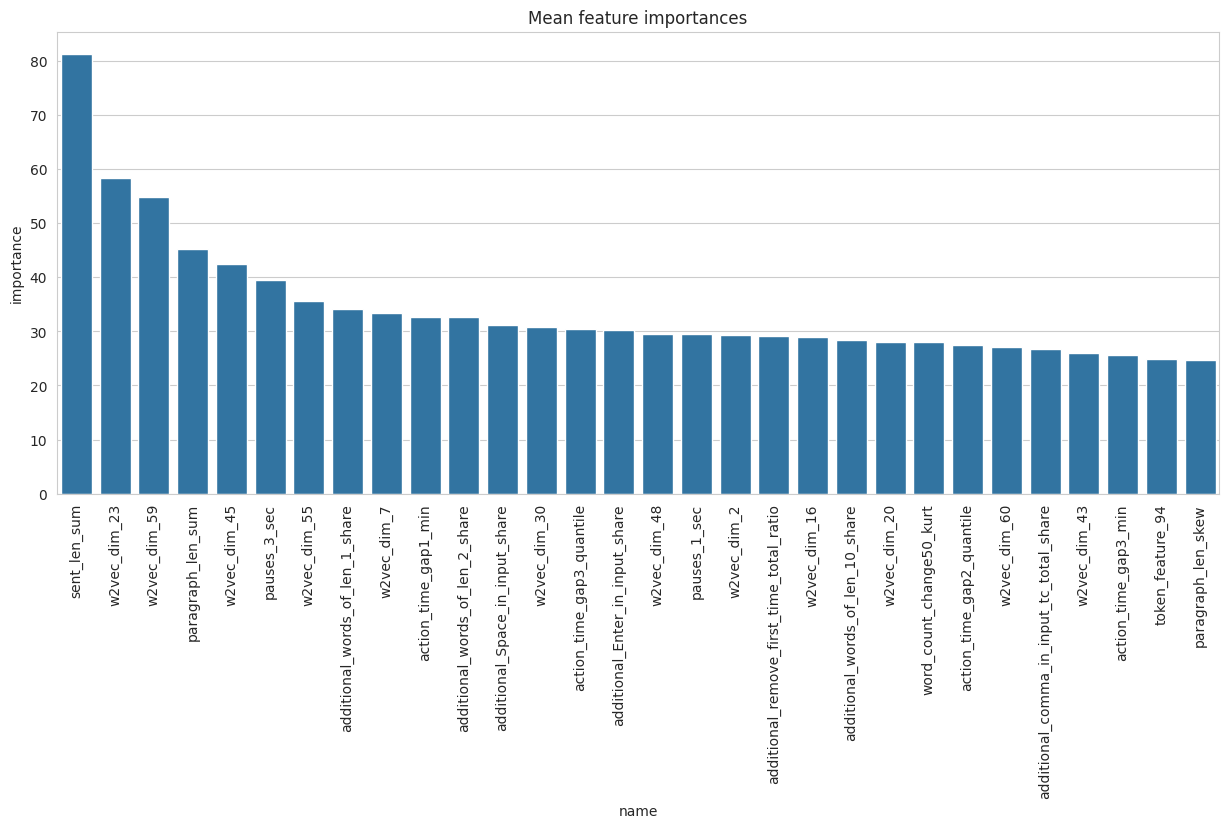

In [212]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(30), x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [213]:
# test_predict_list

In [214]:
if cnfg.is_local:
    # test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
    test_rmse = metrics.mean_squared_error(
        test_feats["score"], np.mean(test_predict_list, axis=0), squared=False
    )
    print("Test Set RMSE Score : ", test_rmse)
else:
    if not cnfg.use_lgb_ftr_selection:
        test_feats["score"] = np.mean(test_predict_list, axis=0)
        test_feats[["id", "score"]].to_csv("submission.csv", index=False)

Test Set RMSE Score :  0.6205270608446417


### Further Feature Selection

In [126]:
if cnfg.use_lgb_ftr_selection:
    top_k_featrs = feature_importance_df.iloc[
        : cnfg.num_top_features
    ].name.values.tolist()

In [129]:
print(top_k_featrs)

['sent_len_sum', 'w2vec_dim_23', 'w2vec_dim_45', 'w2vec_dim_55', 'w2vec_dim_59', 'paragraph_len_sum', 'additional_Space_in_input_share', 'pauses_3_sec', 'pauses_1_sec', 'additional_words_of_len_1_share', 'word_count_change50_kurt', 'w2vec_dim_7', 'token_feature_94', 'w2vec_dim_60', 'action_time_gap3_quantile', 'additional_words_of_len_10_share', 'additional_Enter_in_input_share', 'action_time_gap1_min', 'additional_remove_first_time_total_ratio', 'sent_len_median', 'token_feature_112', 'w2vec_dim_57', 'w2vec_dim_16', 'w2vec_dim_2', 'down_event_8_cnt', 'w2vec_dim_35', 'additional_comma_in_input_tc_total_share', 'w2vec_dim_18', 'additional_blank_space_tc_total_share', 'token_feature_162', 'additional_q_in_input_share', 'tmp_cursor_position_max', 'w2vec_dim_52', 'w2vec_dim_14', 'action_time_gap5_min', 'sent_len_q3', 'w2vec_dim_39', 'paragraph_word_count_std', 'w2vec_dim_0', 'w2vec_dim_28', 'action_time_gap2_quantile', 'w2vec_dim_42', 'paragraph_len_min', 'additional_comma_in_input_share',

In [127]:
if cnfg.use_lgb_ftr_selection:
    train_cols = top_k_featrs

In [128]:
if cnfg.use_lgb_ftr_selection:
    models_dict = {}
    scores = []

    test_predict_list = []

    best_params = {
        "reg_alpha": 0.05924802200631763,
        "reg_lambda": 0.0023346433510371923,
        "feature_fraction": 0.5569998490351998,
        "bagging_fraction": 0.6262979921849824,
        "learning_rate": 0.01180328936041837,
        "num_leaves": 86,
        "min_child_samples": 56,
    }

    # best_params["verbose"] = -1
    # best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

    print(best_params)

    for i in range(5):
        kf = model_selection.KFold(
            n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
        )

        oof_valid_preds = np.zeros(
            train_feats.shape[0],
        )

        X_test = test_feats[train_cols]

        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
            print("==-" * 50)
            print("Fold : ", fold)

            X_train, y_train = (
                train_feats.iloc[train_idx][train_cols],
                train_feats.iloc[train_idx][target_col],
            )
            X_valid, y_valid = (
                train_feats.iloc[valid_idx][train_cols],
                train_feats.iloc[valid_idx][target_col],
            )

            print("Trian :", X_train.shape, y_train.shape)
            print("Valid :", X_valid.shape, y_valid.shape)

            params = {
                "objective": "regression",
                "boosting_type": "gbdt",
                "metric": "rmse",
                # "device_type": "gpu",
                "verbosity": -1,
                "bagging_freq": 1,
                "random_state": cnfg.seed,
                "n_estimators": cnfg.num_estimators,
                **best_params,
            }

            model = lgb.LGBMRegressor(**params)

            early_stopping_callback = lgb.early_stopping(
                cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
            )
            verbose_callback = lgb.log_evaluation(100)

            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=[early_stopping_callback, verbose_callback],
            )

            valid_predict = model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict

            test_predict = model.predict(X_test)
            test_predict_list.append(test_predict)

            score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
            print("Fold RMSE Score : ", score)

            models_dict[f"{fold}_{i}"] = model

        oof_score = metrics.mean_squared_error(
            train_feats[target_col], oof_valid_preds, squared=False
        )
        scores.append(oof_score)
        print("OOF RMSE Score : ", oof_score)

{'reg_alpha': 0.05924802200631763, 'reg_lambda': 0.0023346433510371923, 'feature_fraction': 0.5569998490351998, 'bagging_fraction': 0.6262979921849824, 'learning_rate': 0.01180328936041837, 'num_leaves': 86, 'min_child_samples': 56}
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (1778, 300) (1778, 1)
Valid : (198, 300) (198, 1)
[LightGBM] [Warning] feature_fraction is set=0.5569998490351998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5569998490351998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6262979921849824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6262979921849824
[100]	valid_0's rmse: 0.681978
[200]	valid_0's rmse: 0.619882
[300]	valid_0's rmse: 0.607903
[400]	valid_0's rmse: 0.602762
[500]	valid_0's

In [135]:
if cnfg.use_lgb_ftr_selection:
    feature_importances_values2 = np.asarray(
        [model.feature_importances_ for model in models_dict.values()]
    ).mean(axis=0)
    feature_importance_df2 = pd.DataFrame(
        {"name": train_cols, "importance": feature_importances_values2}
    )

    feature_importance_df2 = feature_importance_df2.sort_values(
        "importance", ascending=False
    )

In [138]:
if cnfg.use_lgb_ftr_selection:
    print(np.mean(scores))

0.5937043828828321


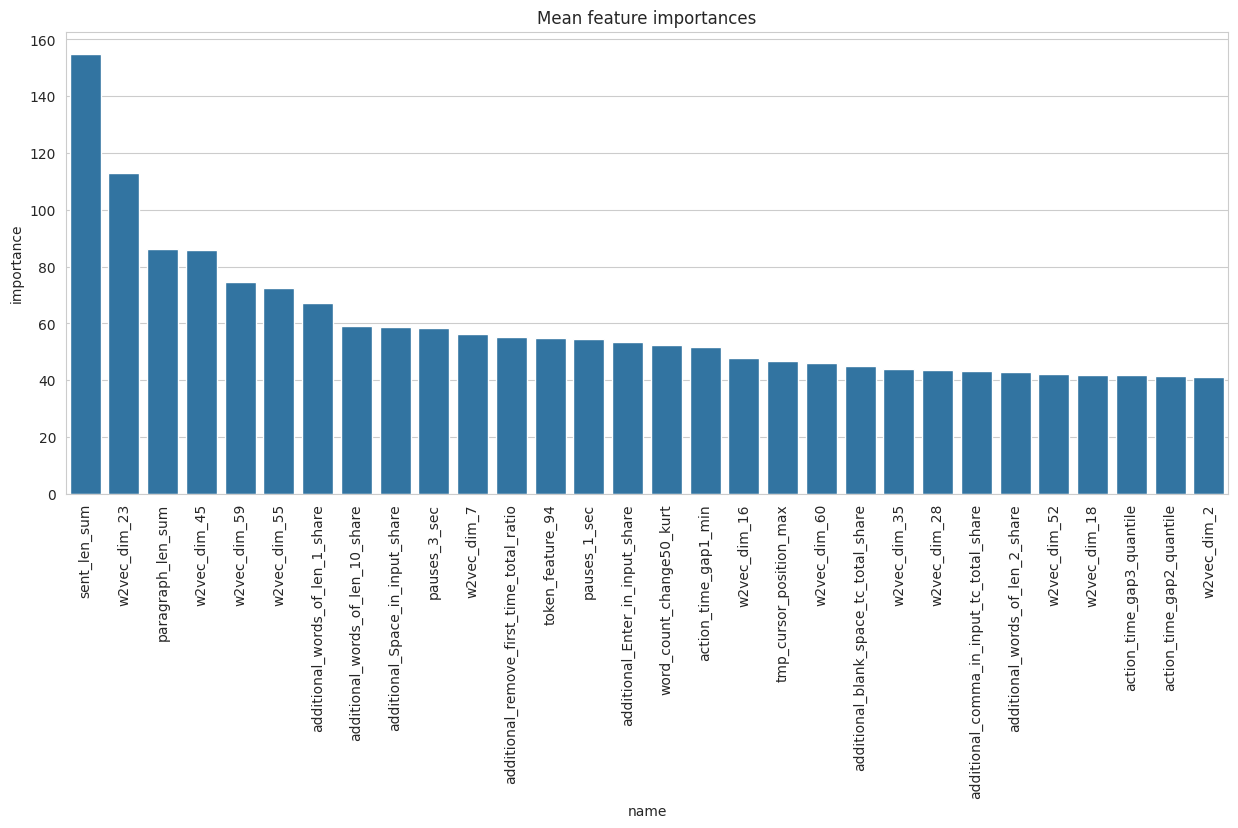

In [137]:
if cnfg.use_lgb_ftr_selection:
    plt.figure(figsize=(15, 6))

    ax = sns.barplot(data=feature_importance_df2.head(30), x="name", y="importance")
    ax.set_title(f"Mean feature importances")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

    plt.show()

In [133]:
if cnfg.is_local:
    # test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
    test_rmse = metrics.mean_squared_error(
        test_feats["score"], np.mean(test_predict_list, axis=0), squared=False
    )
    print("Test Set RMSE Score : ", test_rmse)
else:
    if not cnfg.use_lgb_ftr_selection:
        test_feats["score"] = np.mean(test_predict_list, axis=0)
        test_feats[["id", "score"]].to_csv("submission.csv", index=False)

Test Set RMSE Score :  0.62241472285089


In [140]:
[k for k in top_k_featrs if "burst" in k]

['R-bursts_mean',
 'P-bursts_last',
 'P-bursts_std',
 'P-bursts_max',
 'P-bursts_first',
 'R-bursts_std',
 'P-bursts_count',
 'P-bursts_mean',
 'R-bursts_max']